### Import Libraries

In [73]:
import joblib
import sys
import nltk
import gensim
import time
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle
import re

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import coo_matrix, hstack, csr_matrix
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from scipy import stats
from math import sqrt
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import r2_score
import os
from matplotlib import pyplot as plt
from scipy.stats import norm, skew #for some statistics

from joblib import parallel_backend # added line.
from ray.util.joblib import register_ray # added line.
#from tune_sklearn import TuneGridSearchCV
from scipy.stats import chisquare

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV,HalvingGridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import SGDRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as rs
from sklearn.metrics import mean_absolute_error as mae

from sklearn import svm
# import random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

print("Python Version : ", sys.version)
print("Joblib Version : ", joblib.__version__)

Python Version :  3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Joblib Version :  1.0.1


In [74]:
df_Tickets_new = pd.read_parquet('D:/datascience/support_ticket_classification/ticket_resolution_phase1.parquet', engine='fastparquet')

In [75]:
df_Tickets_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192308 entries, 0 to 192307
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Number             192308 non-null  object 
 1   Priority           192308 non-null  object 
 2   Assignmentgroup    192308 non-null  object 
 3   AssignedTo         162678 non-null  object 
 4   Description        192203 non-null  object 
 5   Closecode          147265 non-null  object 
 6   Resolved by        192261 non-null  object 
 7   Severity           192308 non-null  object 
 8   ConfigurationItem  187416 non-null  object 
 9   Category           191298 non-null  object 
 10  Impact             192306 non-null  object 
 11  Urgency            192308 non-null  object 
 12  Knowledge          192308 non-null  bool   
 13  MadeSLA            192308 non-null  bool   
 14  Reassignmentcount  192308 non-null  int64  
 15  Reopencount        192308 non-null  int64  
 16  Re

In [76]:
df_Tickets_new.isna().sum().to_frame() #Checking null values

0
Number                 0
Priority               0
Assignmentgroup        0
AssignedTo         29630
Description          105
Closecode          45043
Resolved by           47
Severity               0
ConfigurationItem   4892
Category            1010
Impact                 2
Urgency                0
Knowledge              0
MadeSLA                0
Reassignmentcount      0
Reopencount            0
Resolvetime            0
day_of_week            0
month                  0
day                    0
hour                   0
Difference             0
ActualTime             0
ActualTimeHrs          0
Target                 0

In [77]:
df_Tickets_new.shape

(192308, 25)

In [78]:
df_Tickets_new.head()

Number      Priority          Assignmentgroup AssignedTo  \
0  INC0917534       4 - Low        PAN RCI INDIA CAB       None   
1  INC0174710  3 - Moderate        PAN RCI NA NP CAB       None   
2  INC1219770  3 - Moderate  RCI Affiliate Reporting       None   
3  INC0410026       4 - Low  RCI Affiliate Reporting       None   
4  INC1192111       4 - Low  RCI Affiliate Reporting       None   

                                         Description          Closecode  \
0  Please route to IRF should be routed to the RC...               None   
1  EVR Account Page Layout Change Set needs to be...  Backed Out Change   
2  Caller: Yamila Heavy\nContact Phone: (407) 597...               None   
3  Greetings,\nExternal Portal users are getting ...               None   
4  Caller: Remy Delacruz-RU249101\nContact Phone:...               None   

           Resolved by Severity          ConfigurationItem        Category  \
0  Gregg Humerickhouse  3 - Low               Guide Portal        Incident   
1      Sandra Intorcia  3 - Low  Salesforce Office Edition  Infrastructure   
2        Rossetti Wang  3 - Low    OAC Affiliate Reporting         Request   
3  Gregg Humerickhouse  3 - Low                 ResortLink        Incident   
4        Rossetti Wang  3 - Low                 ResortLink         Request   

   ... Reopencount Resolvetime  day_of_week  month  day  hour  Difference  \
0  ...           0     9153435       Monday      4    1    17         105   
1  ...           0        6273    Wednesday      4   26    10           0   
2  ...           0     7084376       Sunday      1   12    15          82   
3  ...           0    53752393    Wednesday     11    1    11         622   
4  ...           0     9935156      Tuesday     12   10    15         115   

  ActualTime  ActualTimeHrs  Target  
0         13    2542.620833     5.0  
1          0       1.742500     1.0  
2         10    1967.882222     5.0  
3         77   14931.220278     5.0  
4         14    2759.765556     5.0  

[5 rows x 25 columns]

#### Normal Distribution 

D:\softwares\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 481.68 and sigma = 2192.66



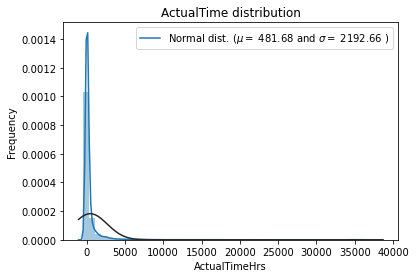

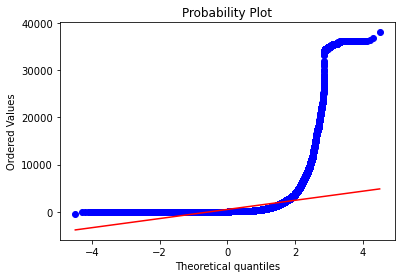

In [79]:
sns.distplot(df_Tickets_new['ActualTimeHrs'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_Tickets_new['ActualTimeHrs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ActualTime distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_Tickets_new['ActualTimeHrs'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

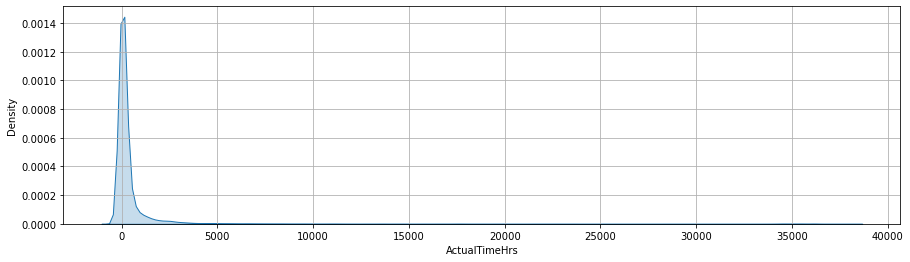

In [80]:
# Lets check the distribution of the dependent variable
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.kdeplot(df_Tickets_new['ActualTimeHrs'],fill=True,cmap="mako")
plt.grid()
plt.show()

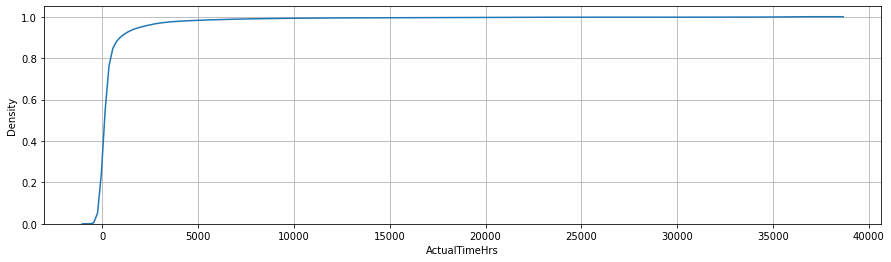

In [81]:
# CDF of the difference
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.kdeplot(df_Tickets_new['ActualTimeHrs'],cumulative=True, common_norm=False, common_grid=True)
plt.grid()
plt.show()

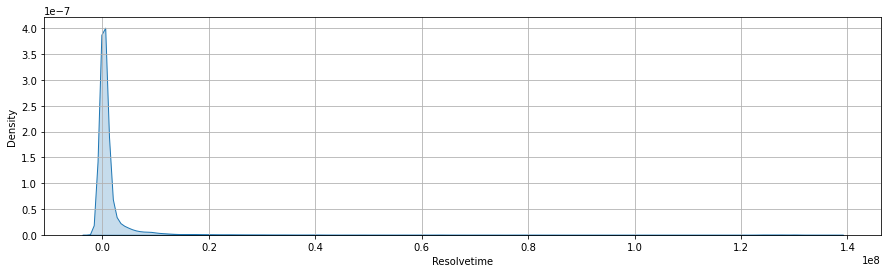

In [82]:
# Lets check the distribution of the dependent variable
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.kdeplot(df_Tickets_new['Resolvetime'],fill=True,cmap="mako")
plt.grid()
plt.show()

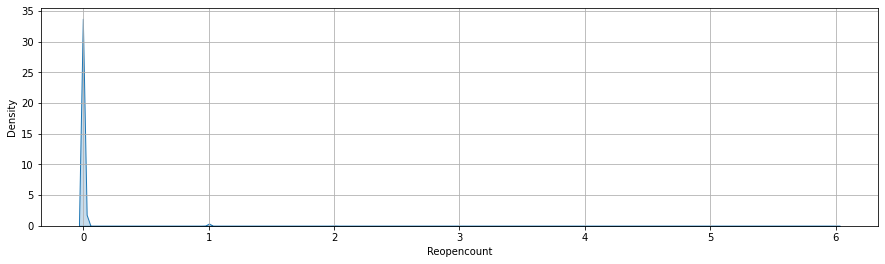

In [83]:
# Lets check the distribution of the dependent variable
fig_dims = (15, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.kdeplot(df_Tickets_new['Reopencount'],fill=True,cmap="mako")
plt.grid()
plt.show()

#### GaussianTranformation - using yeo-johnson power transformation

Transformation of numeric columns into Gaussian Distribution 

In [84]:
num_col_names = ['Reopencount','Reassignmentcount']

In [85]:
target_col_names = ['ActualTimeHrs']

In [86]:
num_features = df_Tickets_new[num_col_names]

In [87]:
# Using Power transformer to get Gaussian Distribution
scaler = PowerTransformer(method = 'yeo-johnson',standardize= True)
df_Tickets_new[num_col_names] = scaler.fit_transform(num_features.values)
df_Tickets_new.head()

Number      Priority          Assignmentgroup AssignedTo  \
0  INC0917534       4 - Low        PAN RCI INDIA CAB       None   
1  INC0174710  3 - Moderate        PAN RCI NA NP CAB       None   
2  INC1219770  3 - Moderate  RCI Affiliate Reporting       None   
3  INC0410026       4 - Low  RCI Affiliate Reporting       None   
4  INC1192111       4 - Low  RCI Affiliate Reporting       None   

                                         Description          Closecode  \
0  Please route to IRF should be routed to the RC...               None   
1  EVR Account Page Layout Change Set needs to be...  Backed Out Change   
2  Caller: Yamila Heavy\nContact Phone: (407) 597...               None   
3  Greetings,\nExternal Portal users are getting ...               None   
4  Caller: Remy Delacruz-RU249101\nContact Phone:...               None   

           Resolved by Severity          ConfigurationItem        Category  \
0  Gregg Humerickhouse  3 - Low               Guide Portal        Incident   
1      Sandra Intorcia  3 - Low  Salesforce Office Edition  Infrastructure   
2        Rossetti Wang  3 - Low    OAC Affiliate Reporting         Request   
3  Gregg Humerickhouse  3 - Low                 ResortLink        Incident   
4        Rossetti Wang  3 - Low                 ResortLink         Request   

   ... Reopencount Resolvetime  day_of_week  month  day  hour  Difference  \
0  ...   -0.110746     9153435       Monday      4    1    17         105   
1  ...   -0.110746        6273    Wednesday      4   26    10           0   
2  ...   -0.110746     7084376       Sunday      1   12    15          82   
3  ...   -0.110746    53752393    Wednesday     11    1    11         622   
4  ...   -0.110746     9935156      Tuesday     12   10    15         115   

  ActualTime  ActualTimeHrs  Target  
0         13    2542.620833     5.0  
1          0       1.742500     1.0  
2         10    1967.882222     5.0  
3         77   14931.220278     5.0  
4         14    2759.765556     5.0  

[5 rows x 25 columns]

In [88]:
target_features = df_Tickets_new[target_col_names]

In [89]:

# Using Power transformer to get Gaussian Distribution
scaler_target = PowerTransformer(method = 'yeo-johnson',standardize= True)
df_Tickets_new[target_col_names] = scaler_target.fit_transform(target_features.values)
df_Tickets_new.head()

Number      Priority          Assignmentgroup AssignedTo  \
0  INC0917534       4 - Low        PAN RCI INDIA CAB       None   
1  INC0174710  3 - Moderate        PAN RCI NA NP CAB       None   
2  INC1219770  3 - Moderate  RCI Affiliate Reporting       None   
3  INC0410026       4 - Low  RCI Affiliate Reporting       None   
4  INC1192111       4 - Low  RCI Affiliate Reporting       None   

                                         Description          Closecode  \
0  Please route to IRF should be routed to the RC...               None   
1  EVR Account Page Layout Change Set needs to be...  Backed Out Change   
2  Caller: Yamila Heavy\nContact Phone: (407) 597...               None   
3  Greetings,\nExternal Portal users are getting ...               None   
4  Caller: Remy Delacruz-RU249101\nContact Phone:...               None   

           Resolved by Severity          ConfigurationItem        Category  \
0  Gregg Humerickhouse  3 - Low               Guide Portal        Incident   
1      Sandra Intorcia  3 - Low  Salesforce Office Edition  Infrastructure   
2        Rossetti Wang  3 - Low    OAC Affiliate Reporting         Request   
3  Gregg Humerickhouse  3 - Low                 ResortLink        Incident   
4        Rossetti Wang  3 - Low                 ResortLink         Request   

   ... Reopencount Resolvetime  day_of_week  month  day  hour  Difference  \
0  ...   -0.110746     9153435       Monday      4    1    17         105   
1  ...   -0.110746        6273    Wednesday      4   26    10           0   
2  ...   -0.110746     7084376       Sunday      1   12    15          82   
3  ...   -0.110746    53752393    Wednesday     11    1    11         622   
4  ...   -0.110746     9935156      Tuesday     12   10    15         115   

  ActualTime  ActualTimeHrs  Target  
0         13       1.810898     5.0  
1          0      -0.501351     1.0  
2         10       1.536761     5.0  
3         77       4.954048     5.0  
4         14       1.905807     5.0  

[5 rows x 25 columns]

In [90]:
pickle.dump(scaler_target, open('D:/datascience/support_ticket_classification/scaler_target.pkl', 'wb'))

In [92]:
scaler_target = pickle.load(open("D:/datascience/support_ticket_classification/scaler_target.pkl", 'rb'))

In [95]:
print(scaler_target)

PowerTransformer()


In [91]:
df_Tickets_new.ActualTimeHrs.quantile([0.05,.1,0.2 ,.25, .5, .75,.8,.85,.9,.95,.96,.97,.98,.99,1])

0.05   -0.536787
0.10   -0.535288
0.20   -0.517055
0.25   -0.499352
0.50   -0.301875
0.75    0.117519
0.80    0.289740
0.85    0.506545
0.90    0.868788
0.95    1.547959
0.96    1.774653
0.97    2.018097
0.98    2.510964
0.99    3.513367
1.00    8.038729
Name: ActualTimeHrs, dtype: float64

D:\softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ActualTimeHrs'>

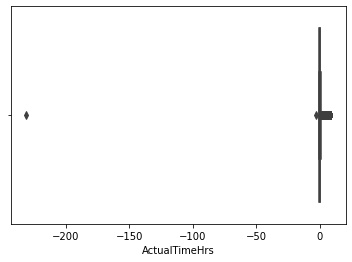

In [71]:
sns.boxplot(df_Tickets_new['ActualTimeHrs'])

Clearly there us outliers but data is not spreaded or has to much variations

D:\softwares\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.00 and sigma = 1.00



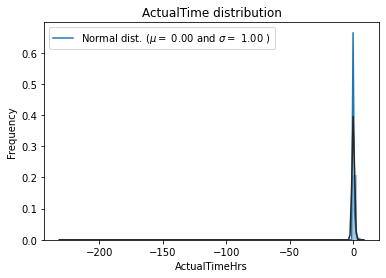

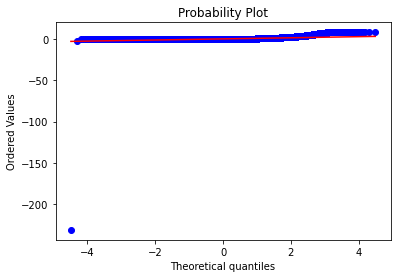

In [72]:
sns.distplot(df_Tickets_new['ActualTimeHrs'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_Tickets_new['ActualTimeHrs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('ActualTime distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_Tickets_new['ActualTimeHrs'], plot=plt)
plt.show()

Removing the skewness and putting into normal distribution . The skew seems now corrected and the data appears more normally distributed.

#### Removing Outliers

In [21]:
percentile25 = df_Tickets_new['ActualTimeHrs'].quantile(0.25)
percentile75 = df_Tickets_new['ActualTimeHrs'].quantile(0.75)

In [22]:
iqr=percentile75-percentile25

In [23]:
print(iqr)

0.6168708263885475


In [24]:
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr

In [25]:
df_Tickets_new[df_Tickets_new['ActualTimeHrs'] > upper_limit]
df_Tickets_new[df_Tickets_new['ActualTimeHrs'] < lower_limit]

Number      Priority            Assignmentgroup      AssignedTo  \
88055   INC1219926  3 - Moderate  WVC Mainframe CSS Support  Gary Sivertsen   
102722  INC1190022  3 - Moderate  WVC Mainframe CSS Support     Guy Bariola   

                                              Description   Closecode  \
88055   VSESPAC - 02:19 ST - Job JPQSRPV2 abended with...  Job Failed   
102722  16:00 ST - VSE NA - Job JAI4BFTP failed with m...  Job Failed   

          Resolved by Severity ConfigurationItem  Category  ... Reopencount  \
88055   Arpita Biswal  3 - Low          CSS - NA  Incident  ...   -0.110746   
102722  Arpita Biswal  3 - Low          CSS - NA  Incident  ...   -0.110746   

       Resolvetime  day_of_week  month  day  hour  Difference ActualTime  \
88055       -86197       Monday      1   13    23          -1          0   
102722    -1727832       Sunday     12   29     6         -20          2   

        ActualTimeHrs  Target  
88055       -3.025996     1.0  
102722    -231.174999     3.0  

[2 rows x 25 columns]

In [26]:
new_df = df_Tickets_new[df_Tickets_new['ActualTimeHrs'] < upper_limit]
new_df.shape

(176079, 25)

D:\softwares\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\softwares\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.w

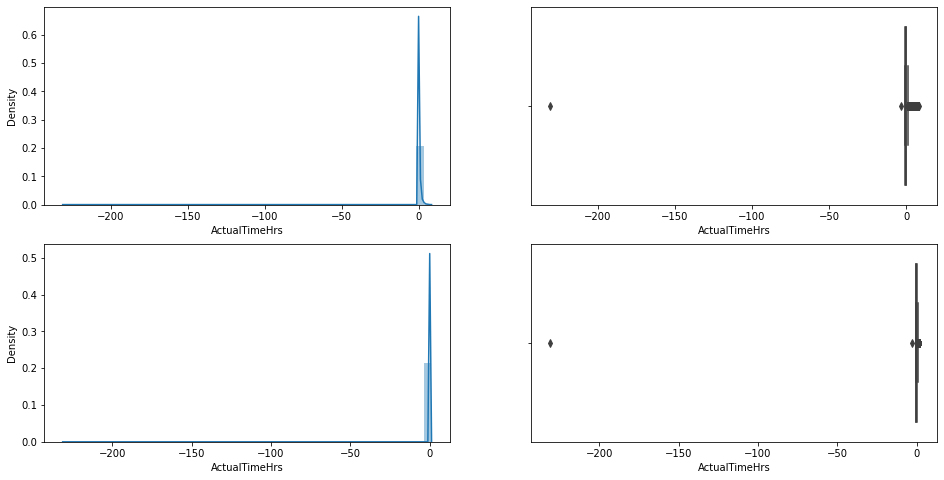

In [27]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.distplot(df_Tickets_new['ActualTimeHrs'])
plt.subplot(2,2,2)
sns.boxplot(df_Tickets_new['ActualTimeHrs'])
plt.subplot(2,2,3)
sns.distplot(new_df['ActualTimeHrs'])
plt.subplot(2,2,4)
sns.boxplot(new_df['ActualTimeHrs'])
plt.show()

We have succefully removed the any outliers which impact the prediction

Lets check the distribution of the dependent variable

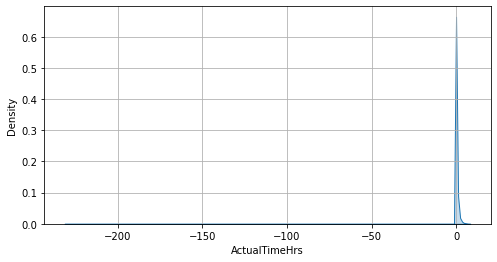

In [28]:
# Lets check the distribution of the dependent variable
fig_dims = (8, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.kdeplot(df_Tickets_new['ActualTimeHrs'],fill=True,cmap="mako")
plt.grid()
plt.show()

In [29]:
df_Tickets_new=new_df.copy()

In [30]:
df_Tickets_new['dow'] = df_Tickets_new['day_of_week'].apply(lambda x: 1 if x=='Sunday' else 0)

In [31]:
df_Tickets_new.head(5)

Number      Priority          Assignmentgroup AssignedTo  \
1   INC0174710  3 - Moderate        PAN RCI NA NP CAB       None   
9   INC0874718       4 - Low  RCI Affiliate Reporting       None   
11  INC0503807       4 - Low  RCI Affiliate Reporting       None   
20  INC0457046       4 - Low  RCI Affiliate Reporting       None   
23  INC1406084       4 - Low  RCI Affiliate Reporting       None   

                                          Description          Closecode  \
1   EVR Account Page Layout Change Set needs to be...  Backed Out Change   
9   Good morning\n\nPlease open a ticket for below...               None   
11  User is unable to pull the data from their RCI...  Permissions Issue   
20  757-821-8425\nNot loading the points active ow...     User Education   
23  Greetings\n\n \nThis user cas no Access to the...               None   

        Resolved by Severity          ConfigurationItem              Category  \
1   Sandra Intorcia  3 - Low  Salesforce Office Edition        Infrastructure   
9     Rossetti Wang  3 - Low                IT Services               Request   
11   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
20   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
23    Rossetti Wang  3 - Low                IT Services              Incident   

    ... Resolvetime day_of_week  month  day  hour  Difference  ActualTime  \
1   ...        6273   Wednesday      4   26    10           0           0   
9   ...     1635425      Friday      2   22    15          18           2   
11  ...      242127     Tuesday      1   30    17           2           0   
20  ...       97464   Wednesday     12   13    10           1           0   
23  ...      103585      Monday      8   24    12           1           0   

   ActualTimeHrs  Target  dow  
1      -0.501351     1.0    0  
9       0.472120     3.0    0  
11     -0.160449     1.0    0  
20     -0.310009     1.0    0  
23     -0.301930     1.0    0  

[5 rows x 26 columns]

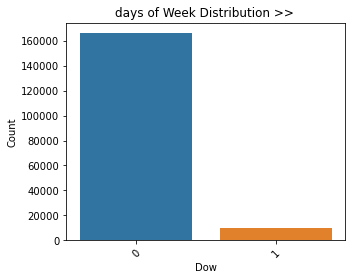

In [32]:
#Plot line graph and view counts of each tickets - After GRP

plt.subplots(figsize = (5,4))

sns.countplot(x='dow', data=df_Tickets_new,order = df_Tickets_new['dow'].value_counts().index)
plt.xlabel('Dow') 
plt.ylabel('Count') 
plt.xticks(rotation=45)
plt.title('days of Week Distribution >> ')
plt.show()

#### Label Encoding some categorical variables that may contain information in their ordering set

In [33]:
# creating instance of labelencoder
#ordinal_encoder = OrdinalEncoder()

In [34]:
#df_Tickets_new.drop('Priority_enco', axis=1, inplace=True)

In [35]:
#df_Tickets_new = df_Tickets_new.dropna(subset=['Impact'], how='all')
#impact_dict = { '3 - Moderate':2,'4 - Low':1,'1 - Critical':4,'2 - High':3}
temp_priority = ['4 - Low', '3 - Moderate', '2 - High', '1 - Critical']
model_priority = OrdinalEncoder(categories=[temp_priority])
df_Tickets_new['Priority']= model_priority.fit_transform(df_Tickets_new[['Priority']])

In [36]:
df_Tickets_new['Impact'].value_counts()

3-Moderate/Limited        106825
4-Minor/Localized          63033
2-Significant/Large         5786
1-Extensive/Widespread       433
Name: Impact, dtype: int64

In [37]:
## Male has higgest frequency. We can also do it by checking the mode
df_Tickets_new['Impact'].mode()

0    3-Moderate/Limited
dtype: object

In [38]:
## Using Frequent Category Imputer
df_Tickets_new['Impact'] = df_Tickets_new['Impact'].fillna('3-Moderate/Limited')

In [39]:
temp_impact = ['4-Minor/Localized', '3-Moderate/Limited', '2-Significant/Large', '1-Extensive/Widespread']
model_impact = OrdinalEncoder(categories=[temp_impact])
df_Tickets_new['Impact']= model_impact.fit_transform(df_Tickets_new[['Impact']])

In [40]:
temp_urgency = ['4-Low', '3-Medium', '2-High', '1-Critical']
model_urgency = OrdinalEncoder(categories=[temp_urgency])
df_Tickets_new['Urgency']= model_urgency.fit_transform(df_Tickets_new[['Urgency']])

In [41]:
#df_Tickets_new['Impact'] = labelencoder.fit_transform(df_Tickets_new['Impact'])
#df_Tickets_new['Priority'] = labelencoder.fit_transform(df_Tickets_new['Priority'])
#df_Tickets_new['Urgency'] = labelencoder.fit_transform(df_Tickets_new['Urgency'])

In [42]:
df_Tickets_new.head(5)

Number  Priority          Assignmentgroup AssignedTo  \
1   INC0174710       1.0        PAN RCI NA NP CAB       None   
9   INC0874718       0.0  RCI Affiliate Reporting       None   
11  INC0503807       0.0  RCI Affiliate Reporting       None   
20  INC0457046       0.0  RCI Affiliate Reporting       None   
23  INC1406084       0.0  RCI Affiliate Reporting       None   

                                          Description          Closecode  \
1   EVR Account Page Layout Change Set needs to be...  Backed Out Change   
9   Good morning\n\nPlease open a ticket for below...               None   
11  User is unable to pull the data from their RCI...  Permissions Issue   
20  757-821-8425\nNot loading the points active ow...     User Education   
23  Greetings\n\n \nThis user cas no Access to the...               None   

        Resolved by Severity          ConfigurationItem              Category  \
1   Sandra Intorcia  3 - Low  Salesforce Office Edition        Infrastructure   
9     Rossetti Wang  3 - Low                IT Services               Request   
11   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
20   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
23    Rossetti Wang  3 - Low                IT Services              Incident   

    ...  Resolvetime  day_of_week  month  day  hour  Difference  ActualTime  \
1   ...         6273    Wednesday      4   26    10           0           0   
9   ...      1635425       Friday      2   22    15          18           2   
11  ...       242127      Tuesday      1   30    17           2           0   
20  ...        97464    Wednesday     12   13    10           1           0   
23  ...       103585       Monday      8   24    12           1           0   

   ActualTimeHrs  Target  dow  
1      -0.501351     1.0    0  
9       0.472120     3.0    0  
11     -0.160449     1.0    0  
20     -0.310009     1.0    0  
23     -0.301930     1.0    0  

[5 rows x 26 columns]

In [43]:
# Adding total sqfootage feature 
#df_Tickets_new['Importance'] = df_Tickets_new['Impact'] + df_Tickets_new['Priority'] + df_Tickets_new['Urgency']

In [44]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()

In [45]:
df_Tickets_new['day_of_week'] = labelencoder.fit_transform(df_Tickets_new['day_of_week'])

In [46]:
df_Tickets_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176079 entries, 1 to 192307
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Number             176079 non-null  object 
 1   Priority           176079 non-null  float64
 2   Assignmentgroup    176079 non-null  object 
 3   AssignedTo         150393 non-null  object 
 4   Description        175975 non-null  object 
 5   Closecode          136674 non-null  object 
 6   Resolved by        176033 non-null  object 
 7   Severity           176079 non-null  object 
 8   ConfigurationItem  171886 non-null  object 
 9   Category           175086 non-null  object 
 10  Impact             176079 non-null  float64
 11  Urgency            176079 non-null  float64
 12  Knowledge          176079 non-null  bool   
 13  MadeSLA            176079 non-null  bool   
 14  Reassignmentcount  176079 non-null  float64
 15  Reopencount        176079 non-null  float64
 16  Re

In [47]:
df_Tickets_new.head()

Number  Priority          Assignmentgroup AssignedTo  \
1   INC0174710       1.0        PAN RCI NA NP CAB       None   
9   INC0874718       0.0  RCI Affiliate Reporting       None   
11  INC0503807       0.0  RCI Affiliate Reporting       None   
20  INC0457046       0.0  RCI Affiliate Reporting       None   
23  INC1406084       0.0  RCI Affiliate Reporting       None   

                                          Description          Closecode  \
1   EVR Account Page Layout Change Set needs to be...  Backed Out Change   
9   Good morning\n\nPlease open a ticket for below...               None   
11  User is unable to pull the data from their RCI...  Permissions Issue   
20  757-821-8425\nNot loading the points active ow...     User Education   
23  Greetings\n\n \nThis user cas no Access to the...               None   

        Resolved by Severity          ConfigurationItem              Category  \
1   Sandra Intorcia  3 - Low  Salesforce Office Edition        Infrastructure   
9     Rossetti Wang  3 - Low                IT Services               Request   
11   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
20   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
23    Rossetti Wang  3 - Low                IT Services              Incident   

    ...  Resolvetime  day_of_week  month  day  hour  Difference  ActualTime  \
1   ...         6273            6      4   26    10           0           0   
9   ...      1635425            0      2   22    15          18           2   
11  ...       242127            5      1   30    17           2           0   
20  ...        97464            6     12   13    10           1           0   
23  ...       103585            1      8   24    12           1           0   

    ActualTimeHrs  Target  dow  
1       -0.501351     1.0    0  
9        0.472120     3.0    0  
11      -0.160449     1.0    0  
20      -0.310009     1.0    0  
23      -0.301930     1.0    0  

[5 rows x 26 columns]

In [48]:
df_Tickets_new = df_Tickets_new.dropna(subset=['Resolved by'], how='all')

In [49]:
df_Tickets_test = df_Tickets_new.copy()

#### Performance of the resolver

In [50]:
df_Tickets_test['MeanAvgEffort'] = df_Tickets_test.groupby('Resolved by')['ActualTimeHrs'].transform('mean')

D:\softwares\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = -0.20 and sigma = 0.67



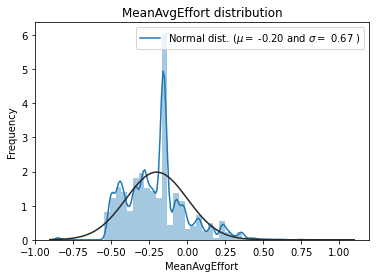

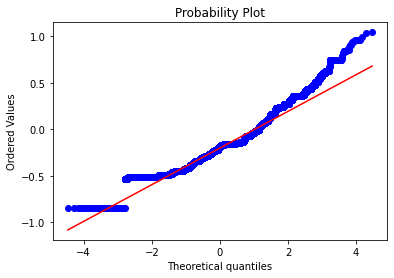

In [267]:
sns.distplot(df_Tickets_test['MeanAvgEffort'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_Tickets_test['ActualTimeHrs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('MeanAvgEffort distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_Tickets_test['MeanAvgEffort'], plot=plt)
plt.show()

D:\softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MeanAvgEffort'>

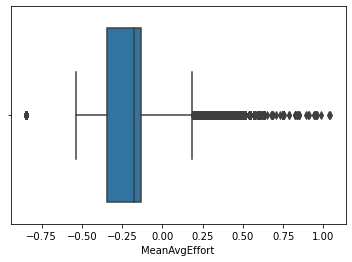

In [268]:
sns.boxplot(df_Tickets_test['MeanAvgEffort'])

In [269]:
num_col_names = ['MeanAvgEffort']
num_features = df_Tickets_test[num_col_names]
# Using Power transformer to get Gaussian Distribution
scaler = PowerTransformer(method = 'yeo-johnson',standardize= True)
df_Tickets_test[num_col_names] = scaler.fit_transform(num_features.values)
df_Tickets_test.head()

Number  Priority          Assignmentgroup AssignedTo  \
1   INC0174710       1.0        PAN RCI NA NP CAB       None   
9   INC0874718       0.0  RCI Affiliate Reporting       None   
11  INC0503807       0.0  RCI Affiliate Reporting       None   
20  INC0457046       0.0  RCI Affiliate Reporting       None   
23  INC1406084       0.0  RCI Affiliate Reporting       None   

                                          Description          Closecode  \
1   EVR Account Page Layout Change Set needs to be...  Backed Out Change   
9   Good morning\n\nPlease open a ticket for below...               None   
11  User is unable to pull the data from their RCI...  Permissions Issue   
20  757-821-8425\nNot loading the points active ow...     User Education   
23  Greetings\n\n \nThis user cas no Access to the...               None   

        Resolved by Severity          ConfigurationItem              Category  \
1   Sandra Intorcia  3 - Low  Salesforce Office Edition        Infrastructure   
9     Rossetti Wang  3 - Low                IT Services               Request   
11   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
20   James Thompson  3 - Low  RCI Affiliates Mobile App  Software/Application   
23    Rossetti Wang  3 - Low                IT Services              Incident   

    ...  day_of_week  month  day  hour  Difference  ActualTime  ActualTimeHrs  \
1   ...            6      4   26    10           0           0      -0.501351   
9   ...            0      2   22    15          18           2       0.472120   
11  ...            5      1   30    17           2           0      -0.160449   
20  ...            6     12   13    10           1           0      -0.310009   
23  ...            1      8   24    12           1           0      -0.301930   

    Target  dow  MeanAvgEffort  
1      1.0    0      -1.701463  
9      3.0    0       1.172641  
11     1.0    0      -0.489069  
20     1.0    0      -0.489069  
23     1.0    0       1.172641  

[5 rows x 27 columns]

D:\softwares\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='MeanAvgEffort'>

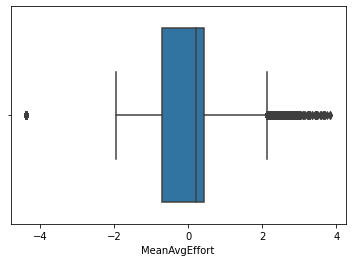

In [270]:
sns.boxplot(df_Tickets_test['MeanAvgEffort'])

D:\softwares\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = -0.20 and sigma = 0.67



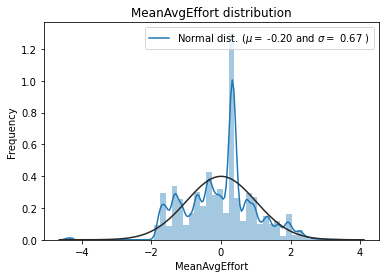

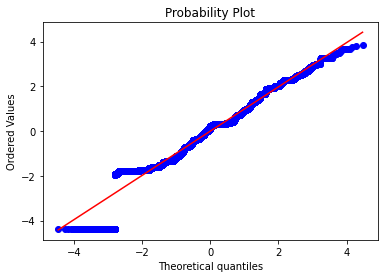

In [271]:
sns.distplot(df_Tickets_test['MeanAvgEffort'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_Tickets_test['ActualTimeHrs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('MeanAvgEffort distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_Tickets_test['MeanAvgEffort'], plot=plt)
plt.show()

We have created a new feature variable which will used to understand the impact of the resolved  by candidate on predicting the solution time
of the ticket

In [272]:
df_Tickets_final = df_Tickets_test.copy()

Removing unwanted columns

In [273]:
#df_Tickets_final.drop('Performance', axis=1, inplace=True)

In [274]:
df_Tickets_final.drop('AssignedTo', axis=1, inplace=True)
df_Tickets_final.drop('Description', axis=1, inplace=True)
df_Tickets_final.drop('Resolved by', axis=1, inplace=True)
#df_Tickets_final.drop('Resolvetime', axis=1, inplace=True)
df_Tickets_final.drop('ActualTime', axis=1, inplace=True)
#df_Tickets_final.drop('MeanAvgEffort', axis=1, inplace=True)
#df_Tickets_final.drop('ActualTimeHrs', axis=1, inplace=True)
df_Tickets_final.drop('Difference', axis=1, inplace=True)
df_Tickets_final.drop('MadeSLA', axis=1, inplace=True)
df_Tickets_final.drop('Knowledge', axis=1, inplace=True)
df_Tickets_final.drop('Closecode', axis=1, inplace=True)
#df_Tickets_final.drop('ConfigurationItem', axis=1, inplace=True)

In [275]:
df_Tickets_feature_test = df_Tickets_final.copy()

In [276]:
df_Tickets_feature_test['Assignmentgroup_l'] = labelencoder.fit_transform(df_Tickets_feature_test['Assignmentgroup'])
df_Tickets_feature_test['Category_l'] = labelencoder.fit_transform(df_Tickets_feature_test['Category'])
df_Tickets_feature_test['ConfigurationItem_l'] = labelencoder.fit_transform(df_Tickets_feature_test['ConfigurationItem'])

In [277]:
df_Tickets_feature_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176033 entries, 1 to 192307
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Number               176033 non-null  object 
 1   Priority             176033 non-null  float64
 2   Assignmentgroup      176033 non-null  object 
 3   Severity             176033 non-null  object 
 4   ConfigurationItem    171842 non-null  object 
 5   Category             175040 non-null  object 
 6   Impact               176033 non-null  float64
 7   Urgency              176033 non-null  float64
 8   Reassignmentcount    176033 non-null  float64
 9   Reopencount          176033 non-null  float64
 10  Resolvetime          176033 non-null  int64  
 11  day_of_week          176033 non-null  int32  
 12  month                176033 non-null  int64  
 13  day                  176033 non-null  int64  
 14  hour                 176033 non-null  int64  
 15  ActualTimeHrs    

In [278]:
df_Tickets_feature_test.head(5)

Number  Priority          Assignmentgroup Severity  \
1   INC0174710       1.0        PAN RCI NA NP CAB  3 - Low   
9   INC0874718       0.0  RCI Affiliate Reporting  3 - Low   
11  INC0503807       0.0  RCI Affiliate Reporting  3 - Low   
20  INC0457046       0.0  RCI Affiliate Reporting  3 - Low   
23  INC1406084       0.0  RCI Affiliate Reporting  3 - Low   

            ConfigurationItem              Category  Impact  Urgency  \
1   Salesforce Office Edition        Infrastructure     1.0      1.0   
9                 IT Services               Request     0.0      1.0   
11  RCI Affiliates Mobile App  Software/Application     0.0      1.0   
20  RCI Affiliates Mobile App  Software/Application     0.0      1.0   
23                IT Services              Incident     1.0      0.0   

    Reassignmentcount  Reopencount  ...  month  day  hour  ActualTimeHrs  \
1           -0.963957    -0.110746  ...      4   26    10      -0.501351   
9            1.717006    -0.110746  ...      2   22    15       0.472120   
11           0.793127    -0.110746  ...      1   30    17      -0.160449   
20           0.793127    -0.110746  ...     12   13    10      -0.310009   
23           1.717006    -0.110746  ...      8   24    12      -0.301930   

    Target  dow  MeanAvgEffort  Assignmentgroup_l  Category_l  \
1      1.0    0      -1.701463                  1           8   
9      3.0    0       1.172641                  4          14   
11     1.0    0      -0.489069                  4          18   
20     1.0    0      -0.489069                  4          18   
23     1.0    0       1.172641                  4           6   

    ConfigurationItem_l  
1                  1572  
9                   681  
11                 1360  
20                 1360  
23                  681  

[5 rows x 22 columns]

#### SNS Plot to understand feature relationships

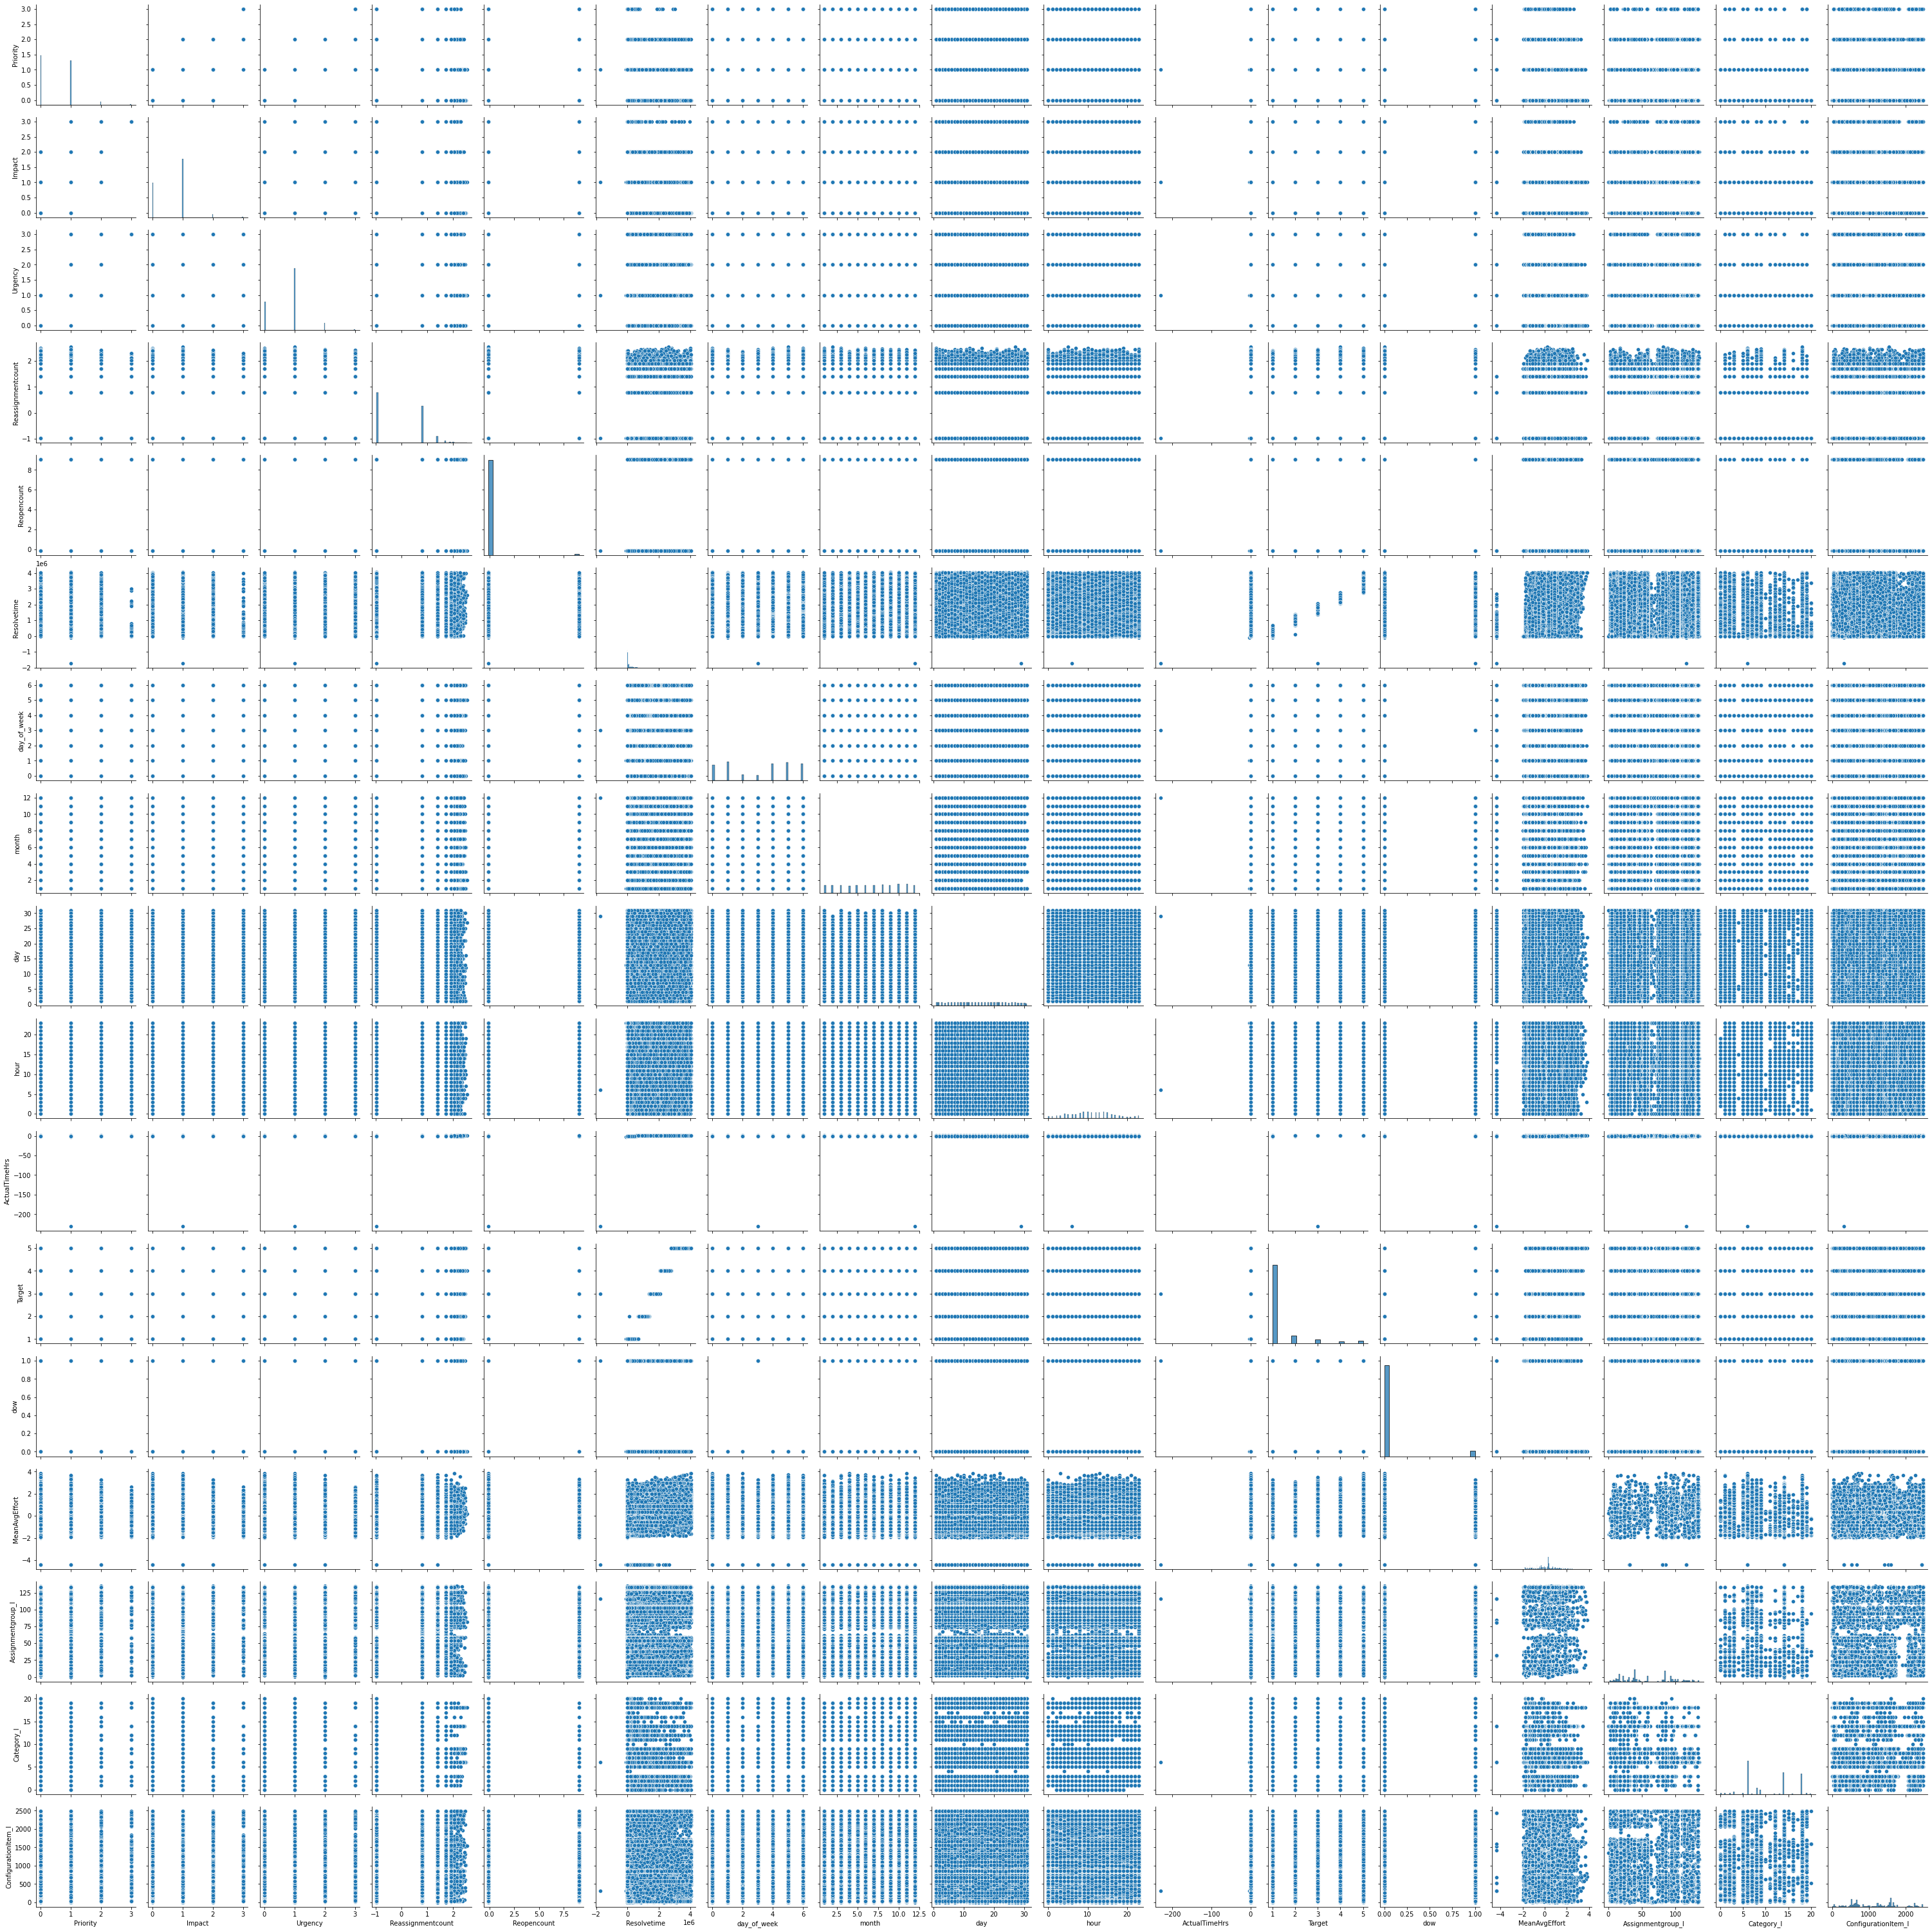

In [279]:
# pairplot of dataframe
import seaborn as sb
sb.pairplot(df_Tickets_feature_test)

array([[<AxesSubplot:title={'center':'Priority'}>,
        <AxesSubplot:title={'center':'Impact'}>,
        <AxesSubplot:title={'center':'Urgency'}>,
        <AxesSubplot:title={'center':'Reassignmentcount'}>],
       [<AxesSubplot:title={'center':'Reopencount'}>,
        <AxesSubplot:title={'center':'Resolvetime'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'month'}>],
       [<AxesSubplot:title={'center':'day'}>,
        <AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'ActualTimeHrs'}>,
        <AxesSubplot:title={'center':'Target'}>],
       [<AxesSubplot:title={'center':'dow'}>,
        <AxesSubplot:title={'center':'MeanAvgEffort'}>,
        <AxesSubplot:title={'center':'Assignmentgroup_l'}>,
        <AxesSubplot:title={'center':'Category_l'}>],
       [<AxesSubplot:title={'center':'ConfigurationItem_l'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

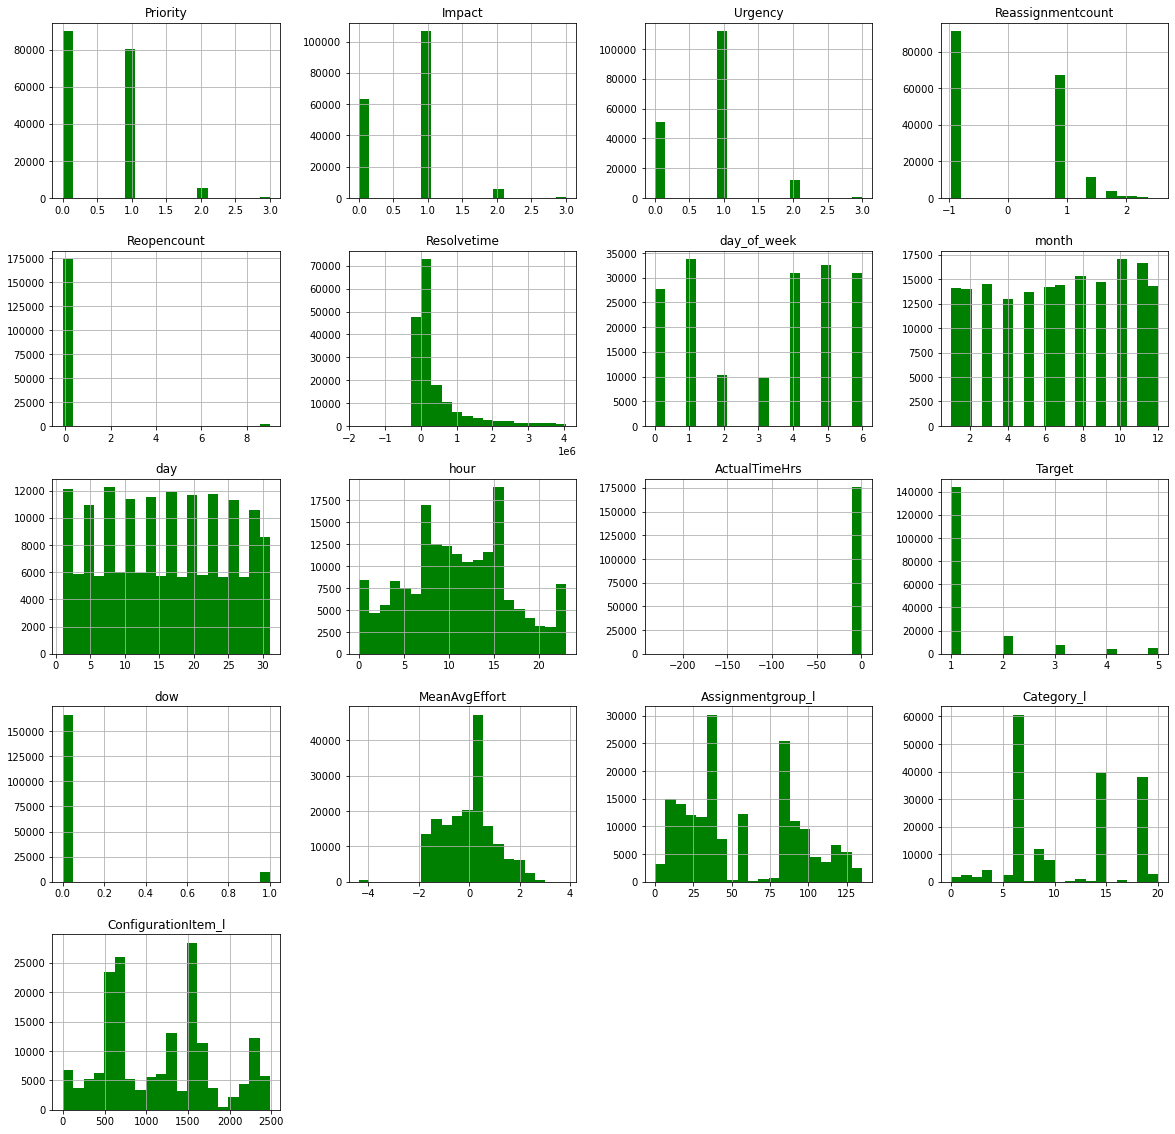

In [280]:
df_Tickets_feature_test.hist(bins = 20, figsize = (20,20), color = 'g')

#### Feature Selection

In [281]:
df_Tickets_final = df_Tickets_feature_test.copy()

In [282]:
df_Tickets_final.drop('Severity', axis=1, inplace=True)


In [283]:
df_Tickets_final.drop('Target', axis=1, inplace=True)

<AxesSubplot:>

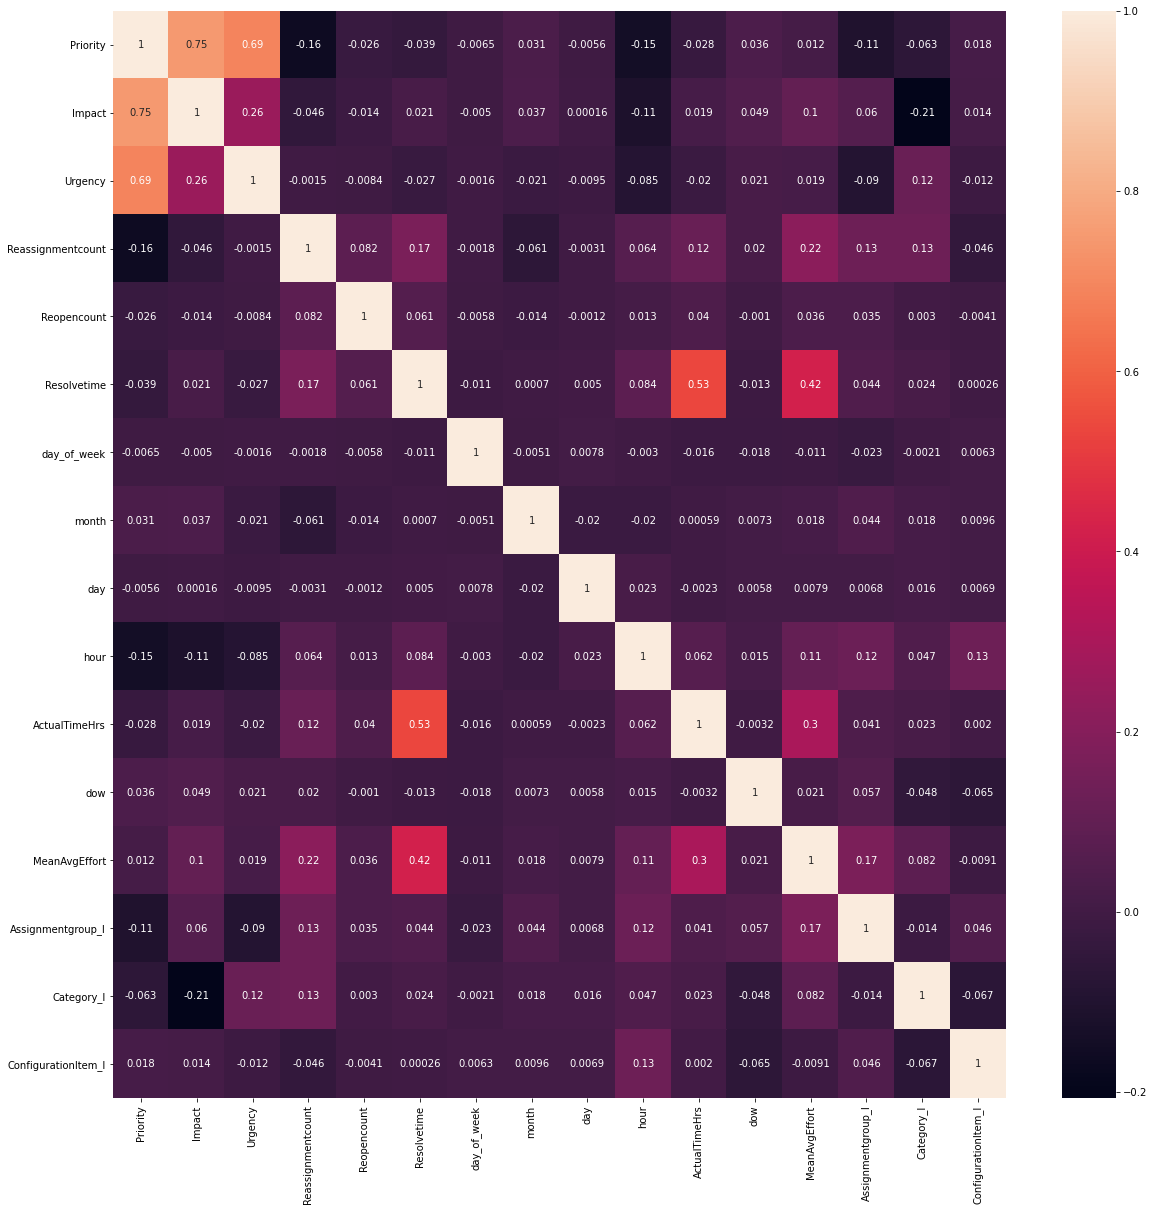

In [284]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(df_Tickets_final.corr(), annot = True)

Heat Map says - Multicollinearity missing and also features has impact on the target variable

In [285]:
df_Tickets_min_max = df_Tickets_final.copy()

In [286]:
df_Tickets_min_max.drop('Assignmentgroup', axis=1, inplace=True)
df_Tickets_min_max.drop('ConfigurationItem', axis=1, inplace=True)
df_Tickets_min_max.drop('Category', axis=1, inplace=True)
df_Tickets_min_max.drop('Resolvetime', axis=1, inplace=True)


In [87]:
df_Tickets_min_max.drop('Number', axis=1, inplace=True)

#### Annova analyis to understand top features variables impacting target variable

In [88]:
def show_top_univariate_filters(x_input, y_target, score_func):
   
    if score_func == "chi2":
        func = chi2
    # Annova
    elif score_func == "f_classif":
        func = f_classif
    elif score_func == "mutual_info_classif":
        func = mutual_info_classif
   
    #apply SelectKBest class to extract top k best features
    bestfeatures = SelectKBest(score_func=func, k=12)
    fit = bestfeatures.fit(x_input,y_target)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x_input.columns)

    #concat two dataframes for better visualization
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(featureScores.nlargest(10,'Score'))  #print top_k best features


In [89]:
data=df_Tickets_min_max.drop(['ActualTimeHrs'],axis=1)
label=df_Tickets_min_max['ActualTimeHrs']

In [90]:
show_top_univariate_filters(data,label,'f_classif')

                Specs     Score
4         Reopencount  3.208541
10      MeanAvgEffort  1.740054
9                 dow  1.709003
3   Reassignmentcount  1.460165
11  Assignmentgroup_l  1.316248
8                hour  1.312301
2             Urgency  1.226308
6               month  1.013197
5         day_of_week  1.007813
0            Priority  1.002974


Reopne count and mean avg effot has the most impact .

In [92]:
df_Tickets_final.shape

(176033, 20)

#### Merge

In [93]:
#df_Tickets_cleaned = pd.read_excel(cleansed_ticket_path,engine='openpyxl')
#cleansed_ticket_path = "C:/Users/119166/Ashish/MTECH/Dissertation/ticket_cleaned.xlsx"
#cleansed_ticket_path = "C:/Users/119166/Ashish/MTECH/Dissertation/ticket_cleaned.xlsx"
cleaned_ticket_pkl = "D:/datascience/support_ticket_classification/cleaned_prediction_ticket_final.pkl"
df_Tickets_text_cleaned =  pd.read_pickle(cleaned_ticket_pkl)

In [94]:
df_Tickets_text_cleaned.head(5)

Number                               finalRemovingPOStags
0  INC0917534   route irf gapm queue angie manager product im...
1  INC0174710   account page layout change need dev sandbox d...
2  INC1219770   caller yamila contact phone hour pm location ...
3  INC0410026                      user screen access resortlink
4  INC1192111   caller remy delacruz ru contact phone fax hou...

In [95]:
df_Tickets_text_cleaned.shape

(192203, 2)

In [96]:
df_final = pd.merge(df_Tickets_final,df_Tickets_text_cleaned,on='Number')

In [97]:
df_final.shape

(175929, 21)

In [98]:
df_final.head(5)

Number  Priority          Assignmentgroup          ConfigurationItem  \
0  INC0174710       1.0        PAN RCI NA NP CAB  Salesforce Office Edition   
1  INC0874718       0.0  RCI Affiliate Reporting                IT Services   
2  INC0503807       0.0  RCI Affiliate Reporting  RCI Affiliates Mobile App   
3  INC0457046       0.0  RCI Affiliate Reporting  RCI Affiliates Mobile App   
4  INC1406084       0.0  RCI Affiliate Reporting                IT Services   

               Category  Impact  Urgency  Reassignmentcount  Reopencount  \
0        Infrastructure     1.0      1.0          -0.975116    -0.110746   
1               Request     0.0      1.0           1.576776    -0.110746   
2  Software/Application     0.0      1.0           0.840610    -0.110746   
3  Software/Application     0.0      1.0           0.840610    -0.110746   
4              Incident     1.0      0.0           1.576776    -0.110746   

   Resolvetime  ...  month  day  hour  ActualTimeHrs  dow  MeanAvgEffort  \
0         6273  ...      4   26    10      -0.501351    0      -1.701463   
1      1635425  ...      2   22    15       0.472120    0       1.172641   
2       242127  ...      1   30    17      -0.160449    0      -0.489069   
3        97464  ...     12   13    10      -0.310009    0      -0.489069   
4       103585  ...      8   24    12      -0.301930    0       1.172641   

   Assignmentgroup_l  Category_l  ConfigurationItem_l  \
0                  1           8                 1572   
1                  4          14                  681   
2                  4          18                 1360   
3                  4          18                 1360   
4                  4           6                  681   

                                finalRemovingPOStags  
0   account page layout change need dev sandbox d...  
1   morning ticket occupancy data sod hsptlty inv...  
2            user pull data reporting site list ruda  
3   point owner date report partner ru ocean ocea...  
4   user access report week point rud welcome jos...  

[5 rows x 21 columns]

In [99]:
df_final.drop('Number', axis=1, inplace=True)

In [100]:
df_final.head(5)

Priority          Assignmentgroup          ConfigurationItem  \
0       1.0        PAN RCI NA NP CAB  Salesforce Office Edition   
1       0.0  RCI Affiliate Reporting                IT Services   
2       0.0  RCI Affiliate Reporting  RCI Affiliates Mobile App   
3       0.0  RCI Affiliate Reporting  RCI Affiliates Mobile App   
4       0.0  RCI Affiliate Reporting                IT Services   

               Category  Impact  Urgency  Reassignmentcount  Reopencount  \
0        Infrastructure     1.0      1.0          -0.975116    -0.110746   
1               Request     0.0      1.0           1.576776    -0.110746   
2  Software/Application     0.0      1.0           0.840610    -0.110746   
3  Software/Application     0.0      1.0           0.840610    -0.110746   
4              Incident     1.0      0.0           1.576776    -0.110746   

   Resolvetime  day_of_week  month  day  hour  ActualTimeHrs  dow  \
0         6273            6      4   26    10      -0.501351    0   
1      1635425            0      2   22    15       0.472120    0   
2       242127            5      1   30    17      -0.160449    0   
3        97464            6     12   13    10      -0.310009    0   
4       103585            1      8   24    12      -0.301930    0   

   MeanAvgEffort  Assignmentgroup_l  Category_l  ConfigurationItem_l  \
0      -1.701463                  1           8                 1572   
1       1.172641                  4          14                  681   
2      -0.489069                  4          18                 1360   
3      -0.489069                  4          18                 1360   
4       1.172641                  4           6                  681   

                                finalRemovingPOStags  
0   account page layout change need dev sandbox d...  
1   morning ticket occupancy data sod hsptlty inv...  
2            user pull data reporting site list ruda  
3   point owner date report partner ru ocean ocea...  
4   user access report week point rud welcome jos...

In [101]:
#countVec.fit(df_final["finalRemovingPOStags"])
#countVec_count = countVec.transform(df_final["finalRemovingPOStags"])
#initial fit representation using transformer object
#tfidfss = tfidf.fit_transform(countVec_count)
#follow similar process to making new data frame with word occurrences, but with term weights
#tfidfssWeightsFin = np.asarray(tfidfss.mean(axis=0)).ravel().tolist()
#now that we've done Tfid, make a dataframe with weights and names
#tweetWeightFrame = pd.DataFrame({'term': countVec.get_feature_names(), 'weight': tfidfssWeightsFin})
#print(tweetWeightFrame)

In [102]:
df_Tickets_final = df_final.copy()

In [103]:
df_Tickets_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175929 entries, 0 to 175928
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Priority              175929 non-null  float64
 1   Assignmentgroup       175929 non-null  object 
 2   ConfigurationItem     171739 non-null  object 
 3   Category              174938 non-null  object 
 4   Impact                175929 non-null  float64
 5   Urgency               175929 non-null  float64
 6   Reassignmentcount     175929 non-null  float64
 7   Reopencount           175929 non-null  float64
 8   Resolvetime           175929 non-null  int64  
 9   day_of_week           175929 non-null  int32  
 10  month                 175929 non-null  int64  
 11  day                   175929 non-null  int64  
 12  hour                  175929 non-null  int64  
 13  ActualTimeHrs         175929 non-null  float64
 14  dow                   175929 non-null  int64  
 15  

In [104]:
#df_Tickets_final.drop('Assignmentgroup', axis=1, inplace=True)
#df_Tickets_final.drop('ConfigurationItem', axis=1, inplace=True)
#df_Tickets_final.drop('Category', axis=1, inplace=True)
df_Tickets_final.drop('Resolvetime', axis=1, inplace=True)
df_Tickets_final.drop('Assignmentgroup_l', axis=1, inplace=True)
df_Tickets_final.drop('Category_l', axis=1, inplace=True)
df_Tickets_final.drop('ConfigurationItem_l', axis=1, inplace=True)
df_Tickets_final.drop('Reopencount', axis=1, inplace=True)

In [105]:
df_Tickets_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175929 entries, 0 to 175928
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Priority              175929 non-null  float64
 1   Assignmentgroup       175929 non-null  object 
 2   ConfigurationItem     171739 non-null  object 
 3   Category              174938 non-null  object 
 4   Impact                175929 non-null  float64
 5   Urgency               175929 non-null  float64
 6   Reassignmentcount     175929 non-null  float64
 7   day_of_week           175929 non-null  int32  
 8   month                 175929 non-null  int64  
 9   day                   175929 non-null  int64  
 10  hour                  175929 non-null  int64  
 11  ActualTimeHrs         175929 non-null  float64
 12  dow                   175929 non-null  int64  
 13  MeanAvgEffort         175929 non-null  float64
 14  finalRemovingPOStags  175929 non-null  object 
dtype

In [287]:
df_Tickets_final.to_parquet('D:/datascience/support_ticket_classification/ticket_resolution_time_classify.parquet') 

In [106]:
#one hot encoding of Assignment group column
assignment_groups = df_Tickets_final['Assignmentgroup']
#type(vehicle_age_types)
assignment_df = pd.DataFrame(assignment_groups,columns=['Assignmentgroup'])
dummy_df = pd.get_dummies(assignment_df, columns=["Assignmentgroup"], prefix=["Assignment_is"] )
df_Tickets_final = df_Tickets_final.join(dummy_df)
#df_Tickets_final.head()

In [107]:
df_Tickets_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175929 entries, 0 to 175928
Columns: 151 entries, Priority to Assignment_is_WVC Workflow Ops
dtypes: float64(6), int32(1), int64(4), object(4), uint8(136)
memory usage: 47.7+ MB


In [108]:
#one hot encoding of Assignment group column
configuration_item = df_Tickets_final['ConfigurationItem']
#type(vehicle_age_types)
configuration_Item_df = pd.DataFrame(configuration_item,columns=['ConfigurationItem'])
dummy_df = pd.get_dummies(configuration_Item_df, columns=["ConfigurationItem"], prefix=["ConfigurationItem_is"] )
df_Tickets_final = df_Tickets_final.join(dummy_df)
#df_Tickets_final.head()

In [109]:
df_Tickets_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175929 entries, 0 to 175928
Columns: 2632 entries, Priority to ConfigurationItem_is_zip
dtypes: float64(6), int32(1), int64(4), object(4), uint8(2617)
memory usage: 463.9+ MB


In [110]:
#one hot encoding of Assignment group column
category = df_Tickets_final['Category']
#type(vehicle_age_types)
category_df = pd.DataFrame(category,columns=['Category'])
dummy_df = pd.get_dummies(category_df, columns=["Category"], prefix=["Category_is"] )
df_Tickets_final = df_Tickets_final.join(dummy_df)
#df_Tickets_final.head()

In [111]:
df_Tickets_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175929 entries, 0 to 175928
Columns: 2652 entries, Priority to Category_is_Telephony
dtypes: float64(6), int32(1), int64(4), object(4), uint8(2637)
memory usage: 467.3+ MB


In [112]:
#one hot encoding of Assignment group column
hourimpact = df_Tickets_final['hour']
#type(vehicle_age_types)
hourimpact_df = pd.DataFrame(hourimpact,columns=['hour'])
dummy_df = pd.get_dummies(hourimpact_df, columns=["hour"], prefix=["hour_is"] )
df_Tickets_final = df_Tickets_final.join(dummy_df)
#df_Tickets_final.head()

In [113]:
#df_Tickets_final = df_Tickets_final.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [114]:
df_Tickets_final.drop('hour', axis=1, inplace=True)

In [115]:
df_Tickets_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175929 entries, 0 to 175928
Columns: 2675 entries, Priority to hour_is_23
dtypes: float64(6), int32(1), int64(3), object(4), uint8(2661)
memory usage: 470.0+ MB


In [116]:
df_Tickets_final = df_Tickets_final.drop(['Category'],axis=1)
df_Tickets_final = df_Tickets_final.drop(['ConfigurationItem'],axis=1)
df_Tickets_final = df_Tickets_final.drop(['Assignmentgroup'],axis=1)

#### Save the final data in parquet format

In [117]:
df_Tickets_final.to_parquet('D:/datascience/support_ticket_classification/ticket_resolution_time.parquet') 

In [188]:
df_Tickets_final = pd.read_parquet('D:/datascience/support_ticket_classification/ticket_resolution_time.parquet', engine='fastparquet')

In [189]:
data=df_Tickets_final.drop(['ActualTimeHrs'],axis=1)
label=df_Tickets_final['ActualTimeHrs']

In [190]:
data.shape

(175929, 2671)

In [191]:
data_test = data.copy()

In [192]:
data_test.shape

(175929, 2671)

In [193]:
data_test = data_test.drop(['finalRemovingPOStags'],axis=1)

In [194]:
data_test.shape

(175929, 2670)

In [195]:
#Normalizing the data using Min-Max normalization technique
#from sklearn import preprocessing
#scaler = preprocessing.MinMaxScaler()
#names = x.columns
#data = scaler.fit_transform(data)
#df_Tickets_final = pd.DataFrame(data)

In [196]:
xtrain,xtest,ytrain,ytest= train_test_split(data_test,label,test_size=0.2,random_state=42)

In [197]:
xtrain.shape

(140743, 2670)

In [198]:
xtest.shape

(35186, 2670)

In [199]:
data.columns

Index(['Priority', 'Impact', 'Urgency', 'Reassignmentcount', 'day_of_week',
       'month', 'day', 'dow', 'MeanAvgEffort', 'finalRemovingPOStags',
       ...
       'hour_is_14', 'hour_is_15', 'hour_is_16', 'hour_is_17', 'hour_is_18',
       'hour_is_19', 'hour_is_20', 'hour_is_21', 'hour_is_22', 'hour_is_23'],
      dtype='object', length=2671)

#### Feature selection 

In [210]:
def feature_ext(model_type,x_input,y_target, x_train, y_train):
    model = RandomForestRegressor()
    sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
    if model_type == 'GBC':
        print('Feature Extraction with GradientBoostingRegressor')
        model = GradientBoostingRegressor()
        sel = SelectFromModel(GradientBoostingRegressor(n_estimators = 100))
    elif model_type == 'ETC':
        print('Feature Extraction with ExtraTreesClassifier')
        model = ExtraTreesRegressor()
        sel = SelectFromModel(ExtraTreesRegressor(n_estimators = 100))
    elif model_type == 'RFC':
        print('Feature Extraction with RandomForestRegressor')
        model = RandomForestRegressor()
        sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
       
    model.fit(x_input,y_target)
    #use inbuilt class feature_importances of tree based classifiers
    print(model.feature_importances_)
   
    #plot graph of feature importances for better visualization
    model.n_features_
    feat_importances = pd.Series(model.feature_importances_, index=x_input.columns)
    feat_importances.nlargest(23).plot(kind='barh')
    plt.show()
    print(feat_importances.nlargest(23))
    sel.fit(x_train, y_train)
    feat_columns = x_train.columns
    print('Featured Columns:')
    feature_list_index = sel.get_support(indices=True)
    return feature_list_index

In [200]:
data_test.shape

(175929, 2670)

Feature Extraction with GradientBoostingRegressor
[0.01231772 0.00016562 0.00288795 ... 0.         0.         0.        ]


C:\Users\ashis\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


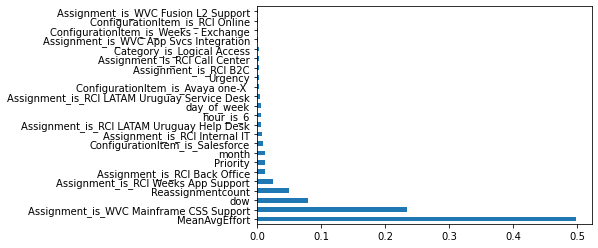

MeanAvgEffort                                   0.497420
Assignment_is_WVC Mainframe CSS Support         0.234516
dow                                             0.079652
Reassignmentcount                               0.049652
Assignment_is_RCI Weeks App Support             0.024932
Assignment_is_RCI Back Office                   0.012797
Priority                                        0.012318
month                                           0.012261
ConfigurationItem_is_Salesforce                 0.009773
Assignment_is_RCI Internal IT                   0.007622
Assignment_is_RCI LATAM Uruguay Help Desk       0.006102
hour_is_6                                       0.006001
day_of_week                                     0.005876
Assignment_is_RCI LATAM Uruguay Service Desk    0.005385
ConfigurationItem_is_Avaya one-X                0.003487
Urgency                                         0.002888
Assignment_is_RCI B2C                           0.002679
Assignment_is_RCI Call Center  

In [211]:
feature_list_index = feature_ext('GBC',data_test,label,xtrain,ytrain)
#sel = feature_ext('GBC',data_test,label,xtrain,ytrain)

In [212]:
#xtrain = sel.transform(xtrain)


In [213]:
#xtest = sel.transform(xtest)

In [214]:
print(feature_list_index)

[   0    2    3    4    5    7    8   17   19   22   40   48   50   68
   89  113  125  352  432  774 1569 1715 2403 2634 2635 2652]


In [215]:
data.shape

(175929, 2671)

In [216]:
#data.drop(data.columns[feature_list_index],axis=1,inplace=True)

In [217]:
#data.shape

In [218]:
#data_final.info()

In [219]:
#drop first column from DataFrame
columns = data.columns
shape = data.shape
index=shape[1]
print(index)

2671


In [220]:
i=0;
data_column =[]
for x in data:
    #print(x)
    index = columns.get_loc(x)
    if (index not in feature_list_index):
        if ( x!='finalRemovingPOStags'):
            #print(x)
            data_column.append(x)
            #data = data.drop([x],axis=1)
            
            
#print(data_column)
data.drop(data_column, axis=1, inplace=True)

In [221]:
data.shape

(175929, 27)

In [222]:
data.columns

Index(['Priority', 'Urgency', 'Reassignmentcount', 'day_of_week', 'month',
       'dow', 'MeanAvgEffort', 'finalRemovingPOStags', 'Assignment_is_RCI B2B',
       'Assignment_is_RCI B2C Tower',
       'Assignment_is_RCI Business Intelligence',
       'Assignment_is_RCI Informatica ETL',
       'Assignment_is_RCI LATAM Mexico Service Desk',
       'Assignment_is_RCI LATAM Uruguay Network',
       'Assignment_is_RCI Web Middleware Support',
       'Assignment_is_WVC App Logging', 'Assignment_is_WVC Focus L2 Support',
       'Assignment_is_WVC Journey CMD', 'ConfigurationItem_is_Avaya Voicemail',
       'ConfigurationItem_is_CMDB', 'ConfigurationItem_is_Guardium',
       'ConfigurationItem_is_RCI Office AddIns',
       'ConfigurationItem_is_Salesforc Shortcut',
       'ConfigurationItem_is_Weeks - Client Contact',
       'Category_is_Informational', 'Category_is_Infrastructure', 'hour_is_5'],
      dtype='object')

In [223]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
countVec = CountVectorizer(max_features= 5000, stop_words='english', min_df=.01, max_df=.90)
tfidf = TfidfTransformer()

text_features = 'finalRemovingPOStags'
text_pipeline = Pipeline([('vect', countVec),
                   ('tfidf', TfidfTransformer())],verbose = True)

In [224]:

# combine preprocessing with ColumnTransformer
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_pipeline, text_features)
],remainder ='passthrough')


In [225]:
## you can just use preprocessor by itself
processed_data = preprocessor.fit_transform(data)

[Pipeline] .............. (step 1 of 2) Processing vect, total=   3.3s
[Pipeline] ............. (step 2 of 2) Processing tfidf, total=   0.1s


In [226]:
# import joblib
from joblib import dump
# dump the pipeline model
dump(preprocessor, filename="D:/datascience/support_ticket_classification/postag_processor.joblib")

['D:/datascience/support_ticket_classification/postag_processor.joblib']

In [227]:
from joblib import load
preprocessor = load("D:/datascience/support_ticket_classification/ticket_assignement_group.joblib")

In [228]:
## you can just use preprocessor by itself
processed_data = preprocessor.transform(data)

In [229]:
processed_data.shape

(175929, 418)

In [231]:
#processed_data.to_parquet('D:/datascience/support_ticket_classification/processes_data.parquet') 
pickle.dump(processed_data, open('D:/datascience/support_ticket_classification/processed_data.pkl', 'wb'))

In [232]:
processed_data = pickle.load(open("D:/datascience/support_ticket_classification/processed_data.pkl", 'rb'))

In [233]:
processed_data.shape

(175929, 418)

In [234]:
##sel_RFC = feature_ext('RFC',data,label,xtrain,ytrain)

In [235]:
xtrain,xtest,ytrain,ytest= train_test_split(processed_data,label,test_size=0.2,random_state=42)

In [236]:
xtrain.shape

(140743, 418)

In [237]:
xtest.shape

(35186, 418)

#### LinearRegression

In [151]:
# import linear regression models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr=LinearRegression()
lr=lr.fit(xtrain,ytrain)

In [152]:
## Predict Train results
y_train_pred = lr.predict(xtrain)
## Predict Test results
y_pred = lr.predict(xtest)

In [153]:
from sklearn.metrics import r2_score
print("Train Results for linear regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for linear regression:
*******************************
Root mean squared error:  0.684768386342553
R-squared:  0.09686939860227983
Mean Absolute Error:  0.22865482314916274


In [154]:
print("Test Results for linear regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for linear regression:
*******************************
Root mean squared error:  0.30794820872456147
R-squared:  0.32441656982073763
Mean Absolute Error:  0.22668671612620273


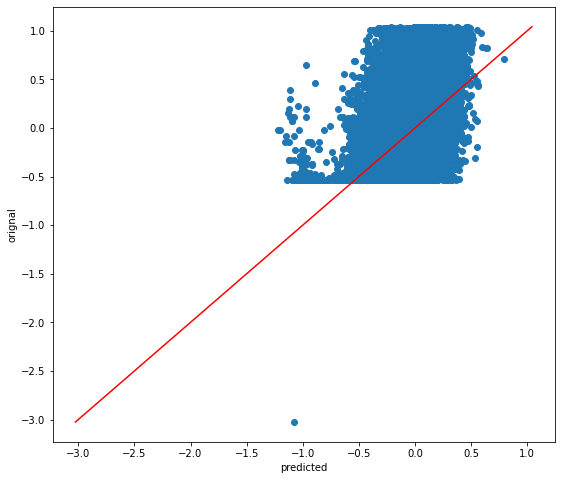

In [155]:
plt.figure(figsize=[9,8])
plt.scatter(y_pred,ytest)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.xlabel('predicted')
plt.ylabel('orignal')
plt.show()

In [156]:
ytest.shape,y_pred.shape

((35186,), (35186,))

In [157]:
def plot_actual_pred(ytest,y_pred):
    fig, ax=plt.subplots(figsize=(15,6))
    sns.lineplot(x=ytest.index,y=ytest,label='Actuals',color='blue',ax=ax)
    sns.lineplot(x=ytest.index,y=y_pred,label='Predictions',color='red',ax=ax)
    ax.set_title('Resolution Time: Actuals vs Predictions', fontsize=16)
    ax.set_ylabel('Resolution Time',fontsize=13)

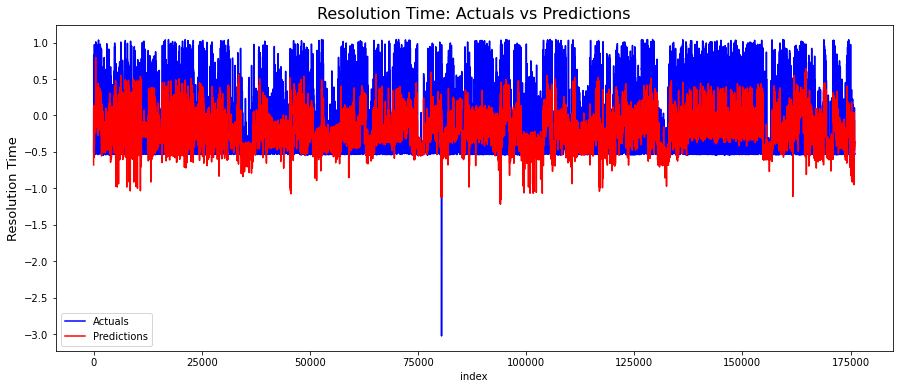

In [158]:
plot_actual_pred(ytest,y_pred)

In [159]:
# import rigd and lasso regresion
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error
rd= Ridge(alpha=0.4)
ls= Lasso(alpha=0.3)
model_rd=rd.fit(xtrain,ytrain)
model_ls = ls.fit(xtrain,ytrain)
#print('score od ridge regression is:-',rd.score(xtest,ytest))
#print('.......................................................')
#print('score of lasso is:-',ls.score(xtest,ytest))
#print('mean_sqrd_roor of ridig is==',mean_squared_error(ytest,rd.predict(xtest)))
#print('mean_sqrd_roor of lasso is==',mean_squared_error(ytest,ls.predict(xtest)))
#print('root_mean_squared error of ridge is==',np.sqrt(mean_squared_error(ytest,rd.predict(xtest))))
#print('root_mean_squared error of lasso is==',np.sqrt(mean_squared_error(ytest,lr.predict(xtest))))

In [160]:
## Predict Train results
y_train_pred = model_rd.predict(xtrain)
## Predict Test results
y_pred = model_rd.predict(xtest)

In [161]:
from sklearn.metrics import r2_score
print("Train Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for Ridge Regression:
*******************************
Root mean squared error:  0.6848350250632589
R-squared:  0.09669361246055297
Mean Absolute Error:  0.2287153199336098


In [162]:
print("Test Results for Ridge Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for Ridge Regression:
*******************************
Root mean squared error:  0.30789357320847516
R-squared:  0.32465626970532446
Mean Absolute Error:  0.22670322830104708


In [163]:
x_predict = list(y_pred)
predicted_df = {'predicted_values': x_predict, 'original_values': ytest}
#creating new dataframe
#rf_pred=model_rd.predict(xtest)
final_def = pd.DataFrame(predicted_df).head(10)
final_def.head(5)

predicted_values  original_values
index                                    
8858           -0.312001        -0.431285
59174          -0.107458        -0.504672
159332         -0.193811        -0.429648
33078          -0.108037        -0.130482
4526           -0.310007        -0.372450

In [164]:
num_feats=['predicted_values']
target_features = final_def[num_feats]

In [165]:
final_def[num_feats] = scaler_target.inverse_transform(target_features.values)

In [166]:
target_feats=['original_values']
target_features = final_def[target_feats]

In [167]:
final_def[target_feats] = scaler_target.inverse_transform(target_features.values)
final_def.head(20)

predicted_values  original_values
index                                    
8858           26.662241         7.775278
59174          86.006404         1.545000
159332         56.678286         7.959722
33078          85.788576        77.565278
4526           27.073897        15.696944
169839          2.978591         1.379722
24662          77.159450         1.782222
111068        197.238756       203.542778
77698          40.509387        40.468889
21368         144.550083       127.707500

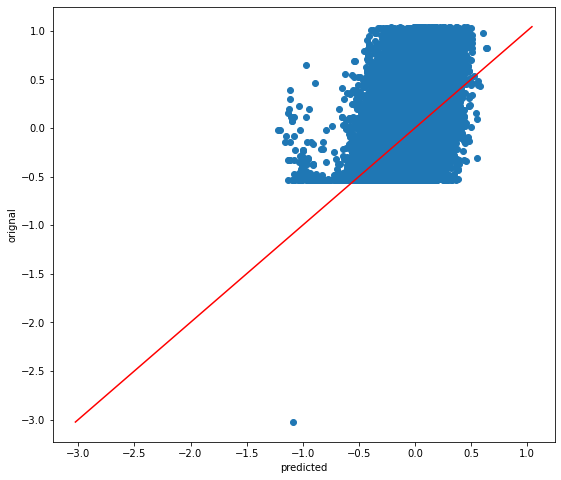

In [168]:
plt.figure(figsize=[9,8])
plt.scatter(y_pred,ytest)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.xlabel('predicted')
plt.ylabel('orignal')
plt.show()

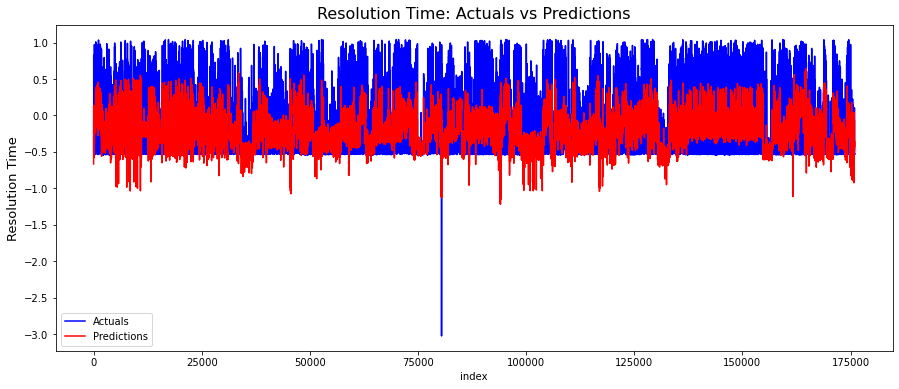

In [169]:
plot_actual_pred(ytest,y_pred)

#### RandomForestRegressor

In [238]:
rnd= RandomForestRegressor(min_samples_leaf=1, min_samples_split=2, n_estimators=100)
fit_rnd= rnd.fit(xtrain,ytrain)

In [239]:
## Predict Train results
y_train_pred = fit_rnd.predict(xtrain)
## Predict Test results
y_pred = fit_rnd.predict(xtest)

In [240]:
print("Train Results for RandomForestRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for RandomForestRegressor
*******************************
Root mean squared error:  0.22506799804683894
R-squared:  0.9024357636153646
Mean Absolute Error:  0.07722910822404391


In [241]:
print("Test Results for RandomForestRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for RandomForestRegressor
*******************************
Root mean squared error:  0.2693155655971187
R-squared:  0.48329039482371183
Mean Absolute Error:  0.179585314517556


In [242]:
x_predict = list(rnd.predict(xtest))
predicted_df = {'predicted_values': x_predict, 'original_values': ytest}
#creating new dataframe
rf_pred=fit_rnd.predict(xtest)
pd.DataFrame(predicted_df).head(20)

predicted_values  original_values
index                                    
8858           -0.395852        -0.431285
59174          -0.226629        -0.504672
159332         -0.366307        -0.429648
33078          -0.124056        -0.130482
4526           -0.352808        -0.372450
169839         -0.508707        -0.507557
24662          -0.383438        -0.500699
111068          0.498782         0.135853
77698          -0.149485        -0.251966
21368           0.207648        -0.008076
58092          -0.273749        -0.244235
117402         -0.420921        -0.531009
55599          -0.280287        -0.532647
52610          -0.456365        -0.536519
82351           0.176307        -0.078914
169944         -0.487345        -0.506663
72141          -0.114371        -0.359046
124738         -0.391415        -0.230578
14816          -0.457768        -0.321488
148928          0.262585         0.664635

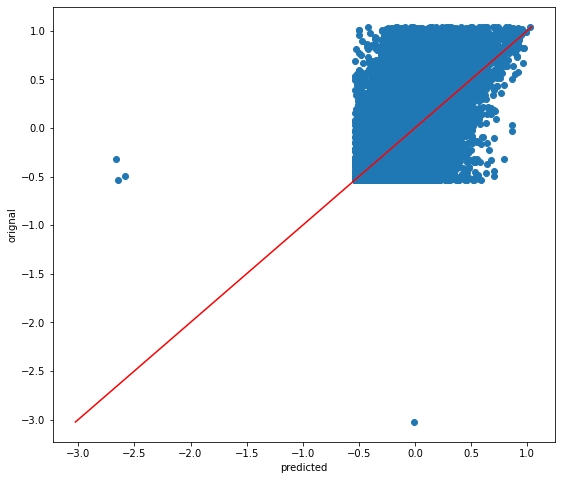

In [243]:
plt.figure(figsize=[9,8])
plt.scatter(y_pred,ytest)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.xlabel('predicted')
plt.ylabel('orignal')
plt.show()

In [176]:
num_feats=['predicted_values']
target_features = final_def[num_feats]
final_def[num_feats] = scaler_target.inverse_transform(target_features.values)
target_feats=['original_values']
target_features = final_def[target_feats]
final_def[target_feats] = scaler_target.inverse_transform(target_features.values)
final_def['predicted_values'] = final_def['predicted_values'].round(decimals = 3)
final_def['original_values'] = final_def['original_values'].round(decimals = 3)
final_def.head(20)

predicted_values  original_values
index                                    
8858        4.352680e+05     3.567073e+04
59174       5.042354e+06     1.984026e+03
159332      2.099402e+06     3.735664e+04
33078       5.015515e+06     4.057415e+06
4526        4.493156e+05     1.462667e+05
169839      5.878182e+03     1.673434e+03
24662       4.012900e+06     2.478859e+03
111068      2.903586e+07     3.103160e+07
77698       1.039465e+06     1.037296e+06
21368       1.506299e+07     1.159828e+07

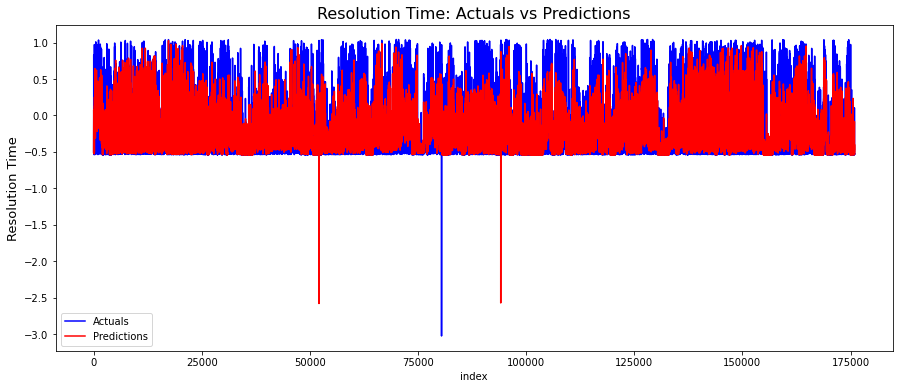

In [177]:
plot_actual_pred(ytest,y_pred)

In [244]:
pickle.dump(fit_rnd, open('D:/datascience/support_ticket_classification/randomforest_normal.pkl', 'wb'))

Using Hyperparameter tuner

In [ ]:
tuned_params = {'n_estimators': [100, 200, 300, 400, 500], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
model_rnd = RandomizedSearchCV(RandomForestRegressor(), tuned_params, n_iter=20, scoring = 'neg_mean_absolute_error', cv=5, n_jobs=5,verbose=50)
model_rnd.fit(xtrain, ytrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
## Predict Train results
y_train_pred = model_rnd.predict(xtrain)

In [ ]:
model_rnd.best_estimator_

In [ ]:
model_rnd.best_score_

In [ ]:
## Predict Test results
y_pred = model_rnd.predict(xtest)

In [ ]:
print("Train Results for Random Forest Regression:")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

In [ ]:
print("Test Results for RandomForestRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

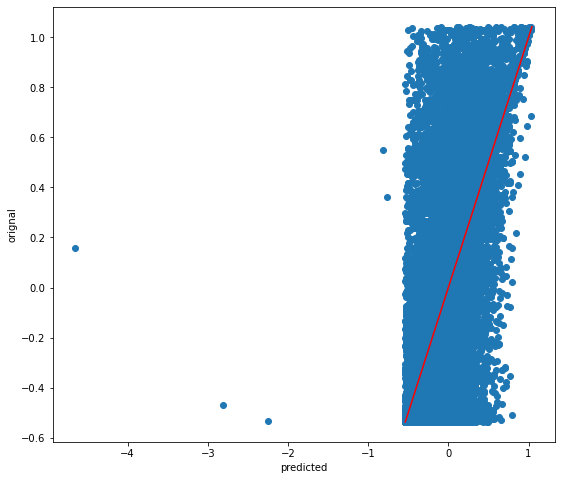

In [35]:
plt.figure(figsize=[9,8])
plt.scatter(y_pred,ytest)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.xlabel('predicted')
plt.ylabel('orignal')
plt.show()

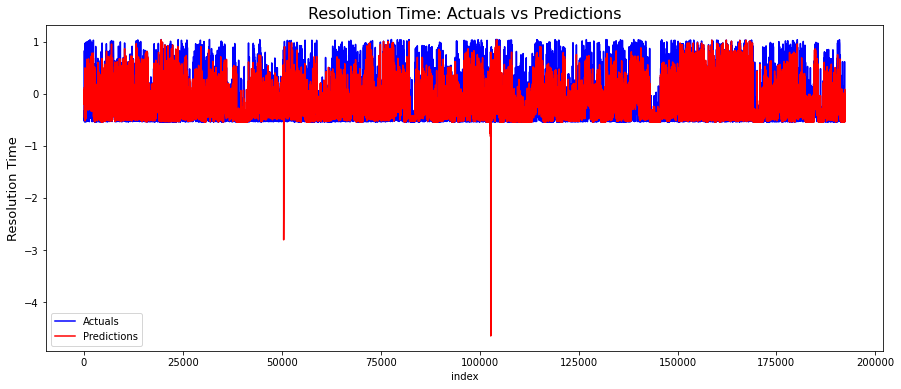

In [39]:
plot_actual_pred(ytest,y_pred)

In [36]:
pickle.dump(model_rnd, open('D:/datascience/support_ticket_classification/randomforest.pkl', 'wb'))

In [40]:
model_rnd = pickle.load(open("D:/datascience/support_ticket_classification/randomforest.pkl", 'rb'))

In [41]:
## Predict Train results
y_train_pred = model_rnd.predict(xtrain)
## Predict Test results
y_pred = model_rnd.predict(xtest)

C:\Users\ashis\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


ValueError: X has 29 features, but RandomForestRegressor is expecting 2646 features as input.

#### CatBoostRegressor

In [179]:
parameters = {'depth': [6,8,10,12],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100, 150]
                 }

In [180]:
from catboost import CatBoostRegressor

cat=CatBoostRegressor()

In [181]:
# grid = GridSearchCV(estimator=cat, param_grid = parameters, cv = 2, n_jobs=-1)

In [182]:

cat_model = cat.fit(xtrain,ytrain)

Learning rate set to 0.08946
0:	learn: 0.7045575	total: 199ms	remaining: 3m 18s
1:	learn: 0.6921853	total: 254ms	remaining: 2m 6s
2:	learn: 0.6780375	total: 310ms	remaining: 1m 43s
3:	learn: 0.6641773	total: 364ms	remaining: 1m 30s
4:	learn: 0.6534341	total: 416ms	remaining: 1m 22s
5:	learn: 0.6409184	total: 471ms	remaining: 1m 18s
6:	learn: 0.6289922	total: 523ms	remaining: 1m 14s
7:	learn: 0.6174949	total: 577ms	remaining: 1m 11s
8:	learn: 0.6145588	total: 636ms	remaining: 1m 10s
9:	learn: 0.6036921	total: 690ms	remaining: 1m 8s
10:	learn: 0.5932595	total: 738ms	remaining: 1m 6s
11:	learn: 0.5866860	total: 786ms	remaining: 1m 4s
12:	learn: 0.5768563	total: 835ms	remaining: 1m 3s
13:	learn: 0.5669112	total: 890ms	remaining: 1m 2s
14:	learn: 0.5579831	total: 942ms	remaining: 1m 1s
15:	learn: 0.5490671	total: 993ms	remaining: 1m 1s
16:	learn: 0.5402703	total: 1.04s	remaining: 1m
17:	learn: 0.5321657	total: 1.1s	remaining: 59.8s
18:	learn: 0.5237965	total: 1.15s	remaining: 59.2s
19:	lear

162:	learn: 0.3034211	total: 8.91s	remaining: 45.8s
163:	learn: 0.3033312	total: 8.97s	remaining: 45.7s
164:	learn: 0.3032377	total: 9.03s	remaining: 45.7s
165:	learn: 0.3031527	total: 9.09s	remaining: 45.7s
166:	learn: 0.3030389	total: 9.15s	remaining: 45.6s
167:	learn: 0.3029337	total: 9.21s	remaining: 45.6s
168:	learn: 0.3024490	total: 9.26s	remaining: 45.5s
169:	learn: 0.3023806	total: 9.31s	remaining: 45.5s
170:	learn: 0.3023180	total: 9.37s	remaining: 45.4s
171:	learn: 0.3018828	total: 9.41s	remaining: 45.3s
172:	learn: 0.3014698	total: 9.46s	remaining: 45.2s
173:	learn: 0.3012935	total: 9.52s	remaining: 45.2s
174:	learn: 0.3011678	total: 9.57s	remaining: 45.1s
175:	learn: 0.3010980	total: 9.63s	remaining: 45.1s
176:	learn: 0.3010313	total: 9.68s	remaining: 45s
177:	learn: 0.3009109	total: 9.73s	remaining: 45s
178:	learn: 0.3005010	total: 9.79s	remaining: 44.9s
179:	learn: 0.3004172	total: 9.84s	remaining: 44.8s
180:	learn: 0.3003395	total: 9.9s	remaining: 44.8s
181:	learn: 0.300

324:	learn: 0.2872472	total: 17.5s	remaining: 36.3s
325:	learn: 0.2872140	total: 17.5s	remaining: 36.3s
326:	learn: 0.2871509	total: 17.6s	remaining: 36.2s
327:	learn: 0.2871036	total: 17.6s	remaining: 36.2s
328:	learn: 0.2870413	total: 17.7s	remaining: 36.1s
329:	learn: 0.2870115	total: 17.8s	remaining: 36.1s
330:	learn: 0.2869529	total: 17.8s	remaining: 36s
331:	learn: 0.2869134	total: 17.9s	remaining: 36s
332:	learn: 0.2867373	total: 17.9s	remaining: 35.9s
333:	learn: 0.2867070	total: 18s	remaining: 35.8s
334:	learn: 0.2866503	total: 18s	remaining: 35.8s
335:	learn: 0.2866043	total: 18.1s	remaining: 35.7s
336:	learn: 0.2865356	total: 18.1s	remaining: 35.7s
337:	learn: 0.2863842	total: 18.2s	remaining: 35.6s
338:	learn: 0.2863418	total: 18.2s	remaining: 35.6s
339:	learn: 0.2863079	total: 18.3s	remaining: 35.5s
340:	learn: 0.2862601	total: 18.4s	remaining: 35.5s
341:	learn: 0.2862083	total: 18.4s	remaining: 35.4s
342:	learn: 0.2861872	total: 18.5s	remaining: 35.4s
343:	learn: 0.286152

485:	learn: 0.2800911	total: 26.4s	remaining: 27.9s
486:	learn: 0.2800699	total: 26.4s	remaining: 27.8s
487:	learn: 0.2800476	total: 26.5s	remaining: 27.8s
488:	learn: 0.2800252	total: 26.5s	remaining: 27.7s
489:	learn: 0.2800022	total: 26.6s	remaining: 27.7s
490:	learn: 0.2799729	total: 26.6s	remaining: 27.6s
491:	learn: 0.2798918	total: 26.7s	remaining: 27.6s
492:	learn: 0.2798646	total: 26.7s	remaining: 27.5s
493:	learn: 0.2798221	total: 26.8s	remaining: 27.5s
494:	learn: 0.2797982	total: 26.9s	remaining: 27.4s
495:	learn: 0.2797753	total: 26.9s	remaining: 27.4s
496:	learn: 0.2797531	total: 27s	remaining: 27.3s
497:	learn: 0.2797244	total: 27s	remaining: 27.2s
498:	learn: 0.2796938	total: 27.1s	remaining: 27.2s
499:	learn: 0.2796672	total: 27.1s	remaining: 27.1s
500:	learn: 0.2796348	total: 27.2s	remaining: 27.1s
501:	learn: 0.2796016	total: 27.2s	remaining: 27s
502:	learn: 0.2795763	total: 27.3s	remaining: 27s
503:	learn: 0.2795478	total: 27.4s	remaining: 26.9s
504:	learn: 0.279518

644:	learn: 0.2752732	total: 35.2s	remaining: 19.4s
645:	learn: 0.2752478	total: 35.3s	remaining: 19.3s
646:	learn: 0.2752026	total: 35.3s	remaining: 19.3s
647:	learn: 0.2751798	total: 35.4s	remaining: 19.2s
648:	learn: 0.2751426	total: 35.4s	remaining: 19.2s
649:	learn: 0.2751185	total: 35.5s	remaining: 19.1s
650:	learn: 0.2750971	total: 35.5s	remaining: 19.1s
651:	learn: 0.2750752	total: 35.6s	remaining: 19s
652:	learn: 0.2750528	total: 35.7s	remaining: 18.9s
653:	learn: 0.2750263	total: 35.7s	remaining: 18.9s
654:	learn: 0.2749965	total: 35.8s	remaining: 18.8s
655:	learn: 0.2749547	total: 35.8s	remaining: 18.8s
656:	learn: 0.2749390	total: 35.9s	remaining: 18.7s
657:	learn: 0.2749271	total: 35.9s	remaining: 18.7s
658:	learn: 0.2749005	total: 36s	remaining: 18.6s
659:	learn: 0.2748794	total: 36.1s	remaining: 18.6s
660:	learn: 0.2748579	total: 36.1s	remaining: 18.5s
661:	learn: 0.2748427	total: 36.2s	remaining: 18.5s
662:	learn: 0.2748234	total: 36.2s	remaining: 18.4s
663:	learn: 0.27

805:	learn: 0.2714883	total: 44.4s	remaining: 10.7s
806:	learn: 0.2714685	total: 44.4s	remaining: 10.6s
807:	learn: 0.2714373	total: 44.5s	remaining: 10.6s
808:	learn: 0.2714120	total: 44.5s	remaining: 10.5s
809:	learn: 0.2713872	total: 44.6s	remaining: 10.5s
810:	learn: 0.2713760	total: 44.6s	remaining: 10.4s
811:	learn: 0.2713101	total: 44.7s	remaining: 10.3s
812:	learn: 0.2712776	total: 44.7s	remaining: 10.3s
813:	learn: 0.2712594	total: 44.8s	remaining: 10.2s
814:	learn: 0.2712377	total: 44.9s	remaining: 10.2s
815:	learn: 0.2712166	total: 44.9s	remaining: 10.1s
816:	learn: 0.2711948	total: 45s	remaining: 10.1s
817:	learn: 0.2711801	total: 45s	remaining: 10s
818:	learn: 0.2711647	total: 45.1s	remaining: 9.96s
819:	learn: 0.2711451	total: 45.1s	remaining: 9.9s
820:	learn: 0.2711233	total: 45.2s	remaining: 9.85s
821:	learn: 0.2711008	total: 45.2s	remaining: 9.79s
822:	learn: 0.2710810	total: 45.3s	remaining: 9.73s
823:	learn: 0.2710534	total: 45.3s	remaining: 9.68s
824:	learn: 0.27102

965:	learn: 0.2684180	total: 52.6s	remaining: 1.85s
966:	learn: 0.2683986	total: 52.7s	remaining: 1.8s
967:	learn: 0.2683930	total: 52.7s	remaining: 1.74s
968:	learn: 0.2683784	total: 52.8s	remaining: 1.69s
969:	learn: 0.2683618	total: 52.8s	remaining: 1.63s
970:	learn: 0.2683508	total: 52.9s	remaining: 1.58s
971:	learn: 0.2683354	total: 52.9s	remaining: 1.52s
972:	learn: 0.2683260	total: 53s	remaining: 1.47s
973:	learn: 0.2683085	total: 53s	remaining: 1.42s
974:	learn: 0.2683013	total: 53.1s	remaining: 1.36s
975:	learn: 0.2682857	total: 53.1s	remaining: 1.31s
976:	learn: 0.2682684	total: 53.2s	remaining: 1.25s
977:	learn: 0.2682536	total: 53.2s	remaining: 1.2s
978:	learn: 0.2682387	total: 53.3s	remaining: 1.14s
979:	learn: 0.2682211	total: 53.3s	remaining: 1.09s
980:	learn: 0.2682112	total: 53.4s	remaining: 1.03s
981:	learn: 0.2681942	total: 53.4s	remaining: 979ms
982:	learn: 0.2681818	total: 53.5s	remaining: 925ms
983:	learn: 0.2681662	total: 53.5s	remaining: 870ms
984:	learn: 0.2681

In [183]:
## Predict Train results
y_train_pred = cat_model.predict(xtrain)
## Predict Test results
y_pred = cat_model.predict(xtest)

In [184]:
print("Train Results for CatBoostRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for CatBoostRegressor
*******************************
Root mean squared error:  0.26790739932147084
R-squared:  0.8617603673977905
Mean Absolute Error:  0.19257558842830472


In [185]:
print("Test Results for CatBoostRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for CatBoostRegressor
*******************************
Root mean squared error:  0.27964459099197814
R-squared:  0.4428957499381895
Mean Absolute Error:  0.19970852459622881


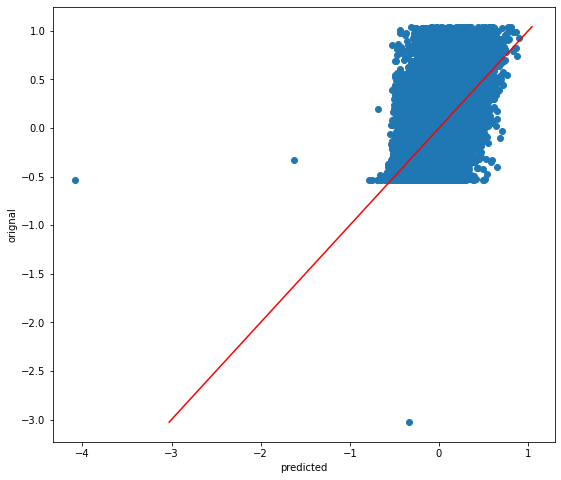

In [186]:
plt.figure(figsize=[9,8])
plt.scatter(y_pred,ytest)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], color='red')
plt.xlabel('predicted')
plt.ylabel('orignal')
plt.show()

In [187]:
pickle.dump(cat_model, open('D:/datascience/support_ticket_classification/catboost.pkl', 'wb'))

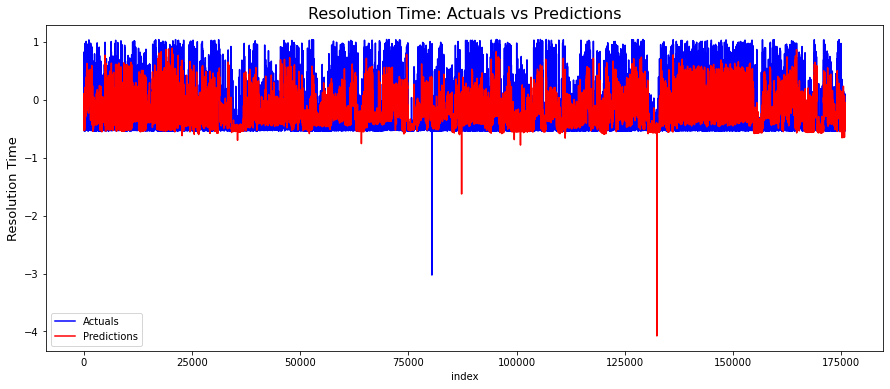

In [188]:
plot_actual_pred(ytest,y_pred)

#### LGBMRegressor

In [189]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor()
lgb_model = lgb_model.fit(xtrain,ytrain)

In [190]:
## Predict Train results
y_train_pred = lgb_model.predict(xtrain)
## Predict Test results
y_pred = lgb_model.predict(xtest)

In [191]:
print("Train Results for LGBMRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for LGBMRegressor
*******************************
Root mean squared error:  0.5196120961531606
R-squared:  0.479978069805889
Mean Absolute Error:  0.205506022149401


In [192]:
print("Test Results for LGBMRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for LGBMRegressor
*******************************
Root mean squared error:  0.30158474918408174
R-squared:  0.3520486833876989
Mean Absolute Error:  0.20639384090338084


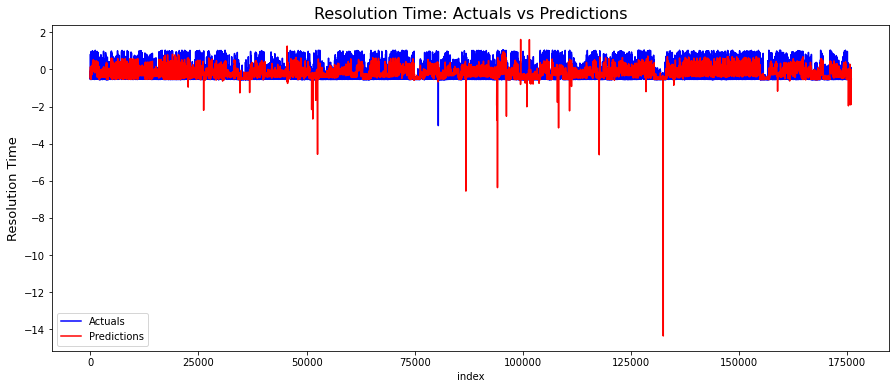

In [193]:
plot_actual_pred(ytest,y_pred)

#### XGBRegressor


In [194]:
# define model
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model = xgb_model.fit(xtrain,ytrain)

[18:44:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [195]:
## Predict Train results
y_train_pred = xgb_model.predict(xtrain)
## Predict Test results
y_pred = xgb_model.predict(xtest)

In [196]:
print("Train Results for XGBRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for XGBRegressor
*******************************
Root mean squared error:  0.3223920861901503
R-squared:  0.7998148310128614
Mean Absolute Error:  0.2183945730468947


In [197]:
print("Test Results for XGBRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for XGBRegressor
*******************************
Root mean squared error:  0.29639524758620356
R-squared:  0.37415599491989593
Mean Absolute Error:  0.21754857217964518


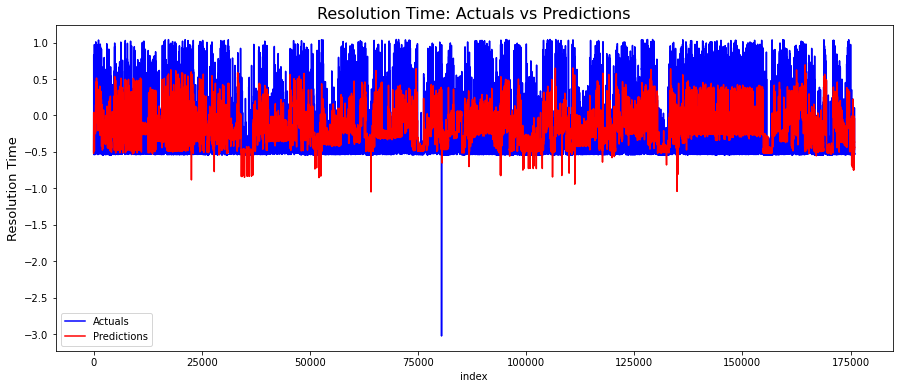

In [198]:
plot_actual_pred(ytest,y_pred)

#### KNN

In [199]:
rmse_val = [] #to store rmse values for different k
for K in range(12):
    K = K+1
    knn_model = KNeighborsRegressor(n_neighbors = K)
    knn_model.fit(xtrain, ytrain)  #fit the model
    ## Predict Train results
    y_train_pred = knn_model.predict(xtrain)
    ## Predict Test results
    y_pred = knn_model.predict(xtest)
    print(" Train Results for KNN ")
    print("*******************************")
    error = sqrt(mse(ytrain.values, y_train_pred))
    print("Root mean squared error: ", error)
    print("R-squared: ", r2_score(ytrain.values, y_train_pred))
    print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))
    print(" Test Results for KNN ")
    print("*******************************")
    print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
    print("R-squared: ", r2_score(ytest, y_pred))
    print("Mean Absolute Error: ", mae(ytest, y_pred))
    rmse_val.append(error) #store rmse values

 Train Results for KNN 
*******************************
Root mean squared error:  0.10389375899575885
R-squared:  0.9792105943462095
Mean Absolute Error:  0.020763398004156972
 Test Results for KNN 
*******************************
Root mean squared error:  0.3699514710502333
R-squared:  0.024980858326153932
Mean Absolute Error:  0.22505927598606015
 Train Results for KNN 
*******************************
Root mean squared error:  0.36437789714124075
R-squared:  0.7442785230009529
Mean Absolute Error:  0.11936423293644711
 Test Results for KNN 
*******************************
Root mean squared error:  0.3296756403981873
R-squared:  0.22572124736411114
Mean Absolute Error:  0.2108123341790081
 Train Results for KNN 
*******************************
Root mean squared error:  0.4675184732132043
R-squared:  0.5790207347467051
Mean Absolute Error:  0.14445118081073688
 Test Results for KNN 
*******************************
Root mean squared error:  0.3153870537162375
R-squared:  0.2913833559047

<AxesSubplot:>

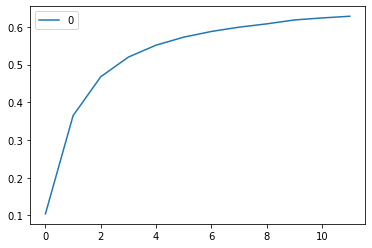

In [200]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

###### SGDRegressor

In [201]:
sfd_model =  SGDRegressor(max_iter=1000, tol=1e-3 , loss='huber',verbose=2,early_stopping=True,penalty='l2',alpha=0.01)
sfd_model =  sfd_model.fit(xtrain,ytrain)

-- Epoch 1
Norm: 0.24, NNZs: 418, Bias: -0.006755, T: 126668, Avg. loss: 0.017354
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.25, NNZs: 418, Bias: -0.010939, T: 253336, Avg. loss: 0.017142
Total training time: 0.07 seconds.
-- Epoch 3
Norm: 0.26, NNZs: 418, Bias: -0.014518, T: 380004, Avg. loss: 0.017079
Total training time: 0.10 seconds.
-- Epoch 4
Norm: 0.26, NNZs: 418, Bias: -0.017749, T: 506672, Avg. loss: 0.017042
Total training time: 0.13 seconds.
-- Epoch 5
Norm: 0.26, NNZs: 418, Bias: -0.020748, T: 633340, Avg. loss: 0.017021
Total training time: 0.16 seconds.
-- Epoch 6
Norm: 0.26, NNZs: 418, Bias: -0.023548, T: 760008, Avg. loss: 0.016996
Total training time: 0.19 seconds.
Convergence after 6 epochs took 0.20 seconds


In [202]:
## Predict Train results
y_train_pred = sfd_model.predict(xtrain)
## Predict Test results
y_pred = sfd_model.predict(xtest)

In [203]:
print("Train Results for SGDRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for SGDRegressor
*******************************
Root mean squared error:  0.6932308796622212
R-squared:  0.07440936100310558
Mean Absolute Error:  0.23402080813174636


In [204]:
print("Test Results for SGDRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for SGDRegressor
*******************************
Root mean squared error:  0.32164602209433835
R-squared:  0.2629787764054914
Mean Absolute Error:  0.23144647021923326


#### Gradient Boosting

In [207]:
model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_GBoost =  model_GBoost.fit(xtrain,ytrain)

In [208]:
## Predict Train results
y_train_pred = model_GBoost.predict(xtrain)
## Predict Test results
y_pred = model_GBoost.predict(xtest)

In [209]:
print("Train Results for GradientBoostingRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for GradientBoostingRegressor
*******************************
Root mean squared error:  0.6737365726610022
R-squared:  0.12573438121812253
Mean Absolute Error:  0.1925230246689723


In [210]:
print("Test Results for GradientBoostingRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for GradientBoostingRegressor
*******************************
Root mean squared error:  0.2841287771920444
R-squared:  0.42488582846618117
Mean Absolute Error:  0.1990560740346789


#### Stacked Regression

In [211]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [212]:
estimators = [('Random Forest', fit_rnd),
              ('CatBoost', cat_model),
              ('Gradient Boosting', model_GBoost)]
#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=CatBoostRegressor())

In [213]:
stacking_regressor =  stacking_regressor.fit(xtrain,ytrain)

Learning rate set to 0.08946
0:	learn: 0.7045575	total: 74.1ms	remaining: 1m 14s
1:	learn: 0.6921853	total: 131ms	remaining: 1m 5s
2:	learn: 0.6780375	total: 192ms	remaining: 1m 3s
3:	learn: 0.6641773	total: 252ms	remaining: 1m 2s
4:	learn: 0.6534341	total: 314ms	remaining: 1m 2s
5:	learn: 0.6409184	total: 373ms	remaining: 1m 1s
6:	learn: 0.6289922	total: 429ms	remaining: 1m
7:	learn: 0.6174949	total: 486ms	remaining: 1m
8:	learn: 0.6145588	total: 550ms	remaining: 1m
9:	learn: 0.6036921	total: 606ms	remaining: 1m
10:	learn: 0.5932595	total: 661ms	remaining: 59.4s
11:	learn: 0.5866860	total: 712ms	remaining: 58.6s
12:	learn: 0.5768563	total: 764ms	remaining: 58s
13:	learn: 0.5669112	total: 819ms	remaining: 57.7s
14:	learn: 0.5579831	total: 875ms	remaining: 57.5s
15:	learn: 0.5490671	total: 930ms	remaining: 57.2s
16:	learn: 0.5402703	total: 984ms	remaining: 56.9s
17:	learn: 0.5321657	total: 1.04s	remaining: 56.7s
18:	learn: 0.5237965	total: 1.09s	remaining: 56.4s
19:	learn: 0.5160308	tot

163:	learn: 0.3033312	total: 9.97s	remaining: 50.8s
164:	learn: 0.3032377	total: 10s	remaining: 50.8s
165:	learn: 0.3031527	total: 10.1s	remaining: 50.8s
166:	learn: 0.3030389	total: 10.2s	remaining: 50.8s
167:	learn: 0.3029337	total: 10.3s	remaining: 50.8s
168:	learn: 0.3024490	total: 10.3s	remaining: 50.8s
169:	learn: 0.3023806	total: 10.4s	remaining: 50.8s
170:	learn: 0.3023180	total: 10.5s	remaining: 50.7s
171:	learn: 0.3018828	total: 10.5s	remaining: 50.7s
172:	learn: 0.3014698	total: 10.6s	remaining: 50.6s
173:	learn: 0.3012935	total: 10.7s	remaining: 50.7s
174:	learn: 0.3011678	total: 10.7s	remaining: 50.6s
175:	learn: 0.3010980	total: 10.8s	remaining: 50.6s
176:	learn: 0.3010313	total: 10.9s	remaining: 50.6s
177:	learn: 0.3009109	total: 10.9s	remaining: 50.5s
178:	learn: 0.3005010	total: 11s	remaining: 50.5s
179:	learn: 0.3004172	total: 11.1s	remaining: 50.5s
180:	learn: 0.3003395	total: 11.2s	remaining: 50.5s
181:	learn: 0.3002714	total: 11.2s	remaining: 50.5s
182:	learn: 0.30

323:	learn: 0.2872781	total: 19.9s	remaining: 41.5s
324:	learn: 0.2872472	total: 20s	remaining: 41.5s
325:	learn: 0.2872140	total: 20s	remaining: 41.4s
326:	learn: 0.2871509	total: 20.1s	remaining: 41.4s
327:	learn: 0.2871036	total: 20.2s	remaining: 41.4s
328:	learn: 0.2870413	total: 20.3s	remaining: 41.4s
329:	learn: 0.2870115	total: 20.4s	remaining: 41.4s
330:	learn: 0.2869529	total: 20.5s	remaining: 41.4s
331:	learn: 0.2869134	total: 20.5s	remaining: 41.3s
332:	learn: 0.2867373	total: 20.6s	remaining: 41.3s
333:	learn: 0.2867070	total: 20.7s	remaining: 41.3s
334:	learn: 0.2866503	total: 20.8s	remaining: 41.4s
335:	learn: 0.2866043	total: 20.9s	remaining: 41.4s
336:	learn: 0.2865356	total: 21s	remaining: 41.4s
337:	learn: 0.2863842	total: 21.1s	remaining: 41.4s
338:	learn: 0.2863418	total: 21.2s	remaining: 41.4s
339:	learn: 0.2863079	total: 21.3s	remaining: 41.4s
340:	learn: 0.2862601	total: 21.4s	remaining: 41.4s
341:	learn: 0.2862083	total: 21.5s	remaining: 41.4s
342:	learn: 0.2861

484:	learn: 0.2801353	total: 31.8s	remaining: 33.8s
485:	learn: 0.2800911	total: 31.9s	remaining: 33.8s
486:	learn: 0.2800699	total: 32s	remaining: 33.7s
487:	learn: 0.2800476	total: 32s	remaining: 33.6s
488:	learn: 0.2800252	total: 32.1s	remaining: 33.5s
489:	learn: 0.2800022	total: 32.2s	remaining: 33.5s
490:	learn: 0.2799729	total: 32.2s	remaining: 33.4s
491:	learn: 0.2798918	total: 32.3s	remaining: 33.3s
492:	learn: 0.2798646	total: 32.4s	remaining: 33.3s
493:	learn: 0.2798221	total: 32.4s	remaining: 33.2s
494:	learn: 0.2797982	total: 32.5s	remaining: 33.1s
495:	learn: 0.2797753	total: 32.5s	remaining: 33.1s
496:	learn: 0.2797531	total: 32.6s	remaining: 33s
497:	learn: 0.2797244	total: 32.7s	remaining: 32.9s
498:	learn: 0.2796938	total: 32.7s	remaining: 32.9s
499:	learn: 0.2796672	total: 32.8s	remaining: 32.8s
500:	learn: 0.2796348	total: 32.9s	remaining: 32.7s
501:	learn: 0.2796016	total: 32.9s	remaining: 32.7s
502:	learn: 0.2795763	total: 33s	remaining: 32.6s
503:	learn: 0.279547

646:	learn: 0.2752026	total: 41.2s	remaining: 22.5s
647:	learn: 0.2751798	total: 41.2s	remaining: 22.4s
648:	learn: 0.2751426	total: 41.3s	remaining: 22.3s
649:	learn: 0.2751185	total: 41.3s	remaining: 22.2s
650:	learn: 0.2750971	total: 41.4s	remaining: 22.2s
651:	learn: 0.2750752	total: 41.4s	remaining: 22.1s
652:	learn: 0.2750528	total: 41.5s	remaining: 22s
653:	learn: 0.2750263	total: 41.5s	remaining: 22s
654:	learn: 0.2749965	total: 41.6s	remaining: 21.9s
655:	learn: 0.2749547	total: 41.7s	remaining: 21.8s
656:	learn: 0.2749390	total: 41.7s	remaining: 21.8s
657:	learn: 0.2749271	total: 41.8s	remaining: 21.7s
658:	learn: 0.2749005	total: 41.8s	remaining: 21.6s
659:	learn: 0.2748794	total: 41.9s	remaining: 21.6s
660:	learn: 0.2748579	total: 41.9s	remaining: 21.5s
661:	learn: 0.2748427	total: 42s	remaining: 21.4s
662:	learn: 0.2748234	total: 42s	remaining: 21.4s
663:	learn: 0.2748027	total: 42.1s	remaining: 21.3s
664:	learn: 0.2747625	total: 42.1s	remaining: 21.2s
665:	learn: 0.274741

807:	learn: 0.2714373	total: 49.9s	remaining: 11.9s
808:	learn: 0.2714120	total: 50s	remaining: 11.8s
809:	learn: 0.2713872	total: 50s	remaining: 11.7s
810:	learn: 0.2713760	total: 50.1s	remaining: 11.7s
811:	learn: 0.2713101	total: 50.2s	remaining: 11.6s
812:	learn: 0.2712776	total: 50.2s	remaining: 11.5s
813:	learn: 0.2712594	total: 50.3s	remaining: 11.5s
814:	learn: 0.2712377	total: 50.3s	remaining: 11.4s
815:	learn: 0.2712166	total: 50.4s	remaining: 11.4s
816:	learn: 0.2711948	total: 50.4s	remaining: 11.3s
817:	learn: 0.2711801	total: 50.5s	remaining: 11.2s
818:	learn: 0.2711647	total: 50.5s	remaining: 11.2s
819:	learn: 0.2711451	total: 50.6s	remaining: 11.1s
820:	learn: 0.2711233	total: 50.7s	remaining: 11s
821:	learn: 0.2711008	total: 50.7s	remaining: 11s
822:	learn: 0.2710810	total: 50.8s	remaining: 10.9s
823:	learn: 0.2710534	total: 50.8s	remaining: 10.9s
824:	learn: 0.2710250	total: 50.9s	remaining: 10.8s
825:	learn: 0.2710054	total: 50.9s	remaining: 10.7s
826:	learn: 0.270976

969:	learn: 0.2683618	total: 59.2s	remaining: 1.83s
970:	learn: 0.2683508	total: 59.2s	remaining: 1.77s
971:	learn: 0.2683354	total: 59.3s	remaining: 1.71s
972:	learn: 0.2683260	total: 59.3s	remaining: 1.65s
973:	learn: 0.2683085	total: 59.4s	remaining: 1.58s
974:	learn: 0.2683013	total: 59.5s	remaining: 1.52s
975:	learn: 0.2682857	total: 59.5s	remaining: 1.46s
976:	learn: 0.2682684	total: 59.6s	remaining: 1.4s
977:	learn: 0.2682536	total: 59.6s	remaining: 1.34s
978:	learn: 0.2682387	total: 59.7s	remaining: 1.28s
979:	learn: 0.2682211	total: 59.8s	remaining: 1.22s
980:	learn: 0.2682112	total: 59.8s	remaining: 1.16s
981:	learn: 0.2681942	total: 59.9s	remaining: 1.1s
982:	learn: 0.2681818	total: 59.9s	remaining: 1.04s
983:	learn: 0.2681662	total: 60s	remaining: 975ms
984:	learn: 0.2681469	total: 1m	remaining: 914ms
985:	learn: 0.2681287	total: 1m	remaining: 853ms
986:	learn: 0.2681224	total: 1m	remaining: 792ms
987:	learn: 0.2680961	total: 1m	remaining: 731ms
988:	learn: 0.2680827	total:

132:	learn: 0.3122271	total: 6.58s	remaining: 42.9s
133:	learn: 0.3121123	total: 6.63s	remaining: 42.8s
134:	learn: 0.3114017	total: 6.68s	remaining: 42.8s
135:	learn: 0.3112885	total: 6.73s	remaining: 42.8s
136:	learn: 0.3109927	total: 6.79s	remaining: 42.7s
137:	learn: 0.3108961	total: 6.84s	remaining: 42.7s
138:	learn: 0.3102788	total: 6.88s	remaining: 42.6s
139:	learn: 0.3096880	total: 6.93s	remaining: 42.6s
140:	learn: 0.3090422	total: 6.98s	remaining: 42.5s
141:	learn: 0.3089409	total: 7.03s	remaining: 42.5s
142:	learn: 0.3088130	total: 7.08s	remaining: 42.5s
143:	learn: 0.3086708	total: 7.14s	remaining: 42.4s
144:	learn: 0.3081390	total: 7.18s	remaining: 42.4s
145:	learn: 0.3076275	total: 7.23s	remaining: 42.3s
146:	learn: 0.3071398	total: 7.28s	remaining: 42.2s
147:	learn: 0.3066591	total: 7.32s	remaining: 42.2s
148:	learn: 0.3061519	total: 7.37s	remaining: 42.1s
149:	learn: 0.3060191	total: 7.42s	remaining: 42.1s
150:	learn: 0.3058559	total: 7.48s	remaining: 42s
151:	learn: 0.

294:	learn: 0.2891565	total: 15s	remaining: 35.9s
295:	learn: 0.2891232	total: 15.1s	remaining: 35.8s
296:	learn: 0.2890750	total: 15.1s	remaining: 35.8s
297:	learn: 0.2890382	total: 15.2s	remaining: 35.7s
298:	learn: 0.2890031	total: 15.2s	remaining: 35.7s
299:	learn: 0.2889552	total: 15.3s	remaining: 35.6s
300:	learn: 0.2889034	total: 15.3s	remaining: 35.6s
301:	learn: 0.2888691	total: 15.4s	remaining: 35.6s
302:	learn: 0.2888220	total: 15.5s	remaining: 35.6s
303:	learn: 0.2887910	total: 15.5s	remaining: 35.6s
304:	learn: 0.2887433	total: 15.6s	remaining: 35.5s
305:	learn: 0.2886891	total: 15.6s	remaining: 35.5s
306:	learn: 0.2886429	total: 15.7s	remaining: 35.4s
307:	learn: 0.2885940	total: 15.7s	remaining: 35.4s
308:	learn: 0.2885399	total: 15.8s	remaining: 35.3s
309:	learn: 0.2884929	total: 15.9s	remaining: 35.3s
310:	learn: 0.2884594	total: 15.9s	remaining: 35.2s
311:	learn: 0.2884187	total: 16s	remaining: 35.2s
312:	learn: 0.2882179	total: 16s	remaining: 35.1s
313:	learn: 0.2881

454:	learn: 0.2811790	total: 25.6s	remaining: 30.6s
455:	learn: 0.2811303	total: 25.6s	remaining: 30.6s
456:	learn: 0.2810644	total: 25.7s	remaining: 30.5s
457:	learn: 0.2810313	total: 25.7s	remaining: 30.5s
458:	learn: 0.2809928	total: 25.8s	remaining: 30.4s
459:	learn: 0.2809888	total: 25.9s	remaining: 30.4s
460:	learn: 0.2809848	total: 25.9s	remaining: 30.3s
461:	learn: 0.2809572	total: 26s	remaining: 30.3s
462:	learn: 0.2808539	total: 26.1s	remaining: 30.2s
463:	learn: 0.2808226	total: 26.1s	remaining: 30.2s
464:	learn: 0.2807720	total: 26.2s	remaining: 30.2s
465:	learn: 0.2806802	total: 26.3s	remaining: 30.1s
466:	learn: 0.2806759	total: 26.3s	remaining: 30.1s
467:	learn: 0.2806438	total: 26.4s	remaining: 30s
468:	learn: 0.2806060	total: 26.5s	remaining: 30s
469:	learn: 0.2805774	total: 26.6s	remaining: 29.9s
470:	learn: 0.2805511	total: 26.6s	remaining: 29.9s
471:	learn: 0.2804912	total: 26.7s	remaining: 29.9s
472:	learn: 0.2804693	total: 26.8s	remaining: 29.8s
473:	learn: 0.2804

614:	learn: 0.2759645	total: 35.1s	remaining: 22s
615:	learn: 0.2759351	total: 35.2s	remaining: 21.9s
616:	learn: 0.2759054	total: 35.2s	remaining: 21.9s
617:	learn: 0.2758822	total: 35.3s	remaining: 21.8s
618:	learn: 0.2758279	total: 35.3s	remaining: 21.8s
619:	learn: 0.2758024	total: 35.4s	remaining: 21.7s
620:	learn: 0.2757383	total: 35.5s	remaining: 21.6s
621:	learn: 0.2757199	total: 35.5s	remaining: 21.6s
622:	learn: 0.2756947	total: 35.6s	remaining: 21.5s
623:	learn: 0.2756702	total: 35.6s	remaining: 21.5s
624:	learn: 0.2756352	total: 35.7s	remaining: 21.4s
625:	learn: 0.2756050	total: 35.8s	remaining: 21.4s
626:	learn: 0.2755767	total: 35.9s	remaining: 21.3s
627:	learn: 0.2755581	total: 35.9s	remaining: 21.3s
628:	learn: 0.2755349	total: 36s	remaining: 21.2s
629:	learn: 0.2755144	total: 36.1s	remaining: 21.2s
630:	learn: 0.2754832	total: 36.1s	remaining: 21.1s
631:	learn: 0.2754797	total: 36.2s	remaining: 21.1s
632:	learn: 0.2754680	total: 36.2s	remaining: 21s
633:	learn: 0.2754

774:	learn: 0.2718047	total: 43.1s	remaining: 12.5s
775:	learn: 0.2717854	total: 43.1s	remaining: 12.4s
776:	learn: 0.2717643	total: 43.2s	remaining: 12.4s
777:	learn: 0.2717450	total: 43.2s	remaining: 12.3s
778:	learn: 0.2717218	total: 43.3s	remaining: 12.3s
779:	learn: 0.2717155	total: 43.3s	remaining: 12.2s
780:	learn: 0.2716869	total: 43.3s	remaining: 12.2s
781:	learn: 0.2716704	total: 43.4s	remaining: 12.1s
782:	learn: 0.2716535	total: 43.4s	remaining: 12s
783:	learn: 0.2716327	total: 43.5s	remaining: 12s
784:	learn: 0.2715995	total: 43.5s	remaining: 11.9s
785:	learn: 0.2715845	total: 43.5s	remaining: 11.9s
786:	learn: 0.2715609	total: 43.6s	remaining: 11.8s
787:	learn: 0.2715372	total: 43.6s	remaining: 11.7s
788:	learn: 0.2715176	total: 43.7s	remaining: 11.7s
789:	learn: 0.2714878	total: 43.7s	remaining: 11.6s
790:	learn: 0.2714565	total: 43.8s	remaining: 11.6s
791:	learn: 0.2714330	total: 43.8s	remaining: 11.5s
792:	learn: 0.2714149	total: 43.9s	remaining: 11.4s
793:	learn: 0.27

935:	learn: 0.2682814	total: 50.2s	remaining: 3.43s
936:	learn: 0.2682631	total: 50.2s	remaining: 3.38s
937:	learn: 0.2682403	total: 50.3s	remaining: 3.32s
938:	learn: 0.2682134	total: 50.3s	remaining: 3.27s
939:	learn: 0.2681911	total: 50.4s	remaining: 3.21s
940:	learn: 0.2681752	total: 50.4s	remaining: 3.16s
941:	learn: 0.2681448	total: 50.5s	remaining: 3.11s
942:	learn: 0.2681192	total: 50.5s	remaining: 3.05s
943:	learn: 0.2680925	total: 50.6s	remaining: 3s
944:	learn: 0.2680659	total: 50.6s	remaining: 2.94s
945:	learn: 0.2680575	total: 50.7s	remaining: 2.89s
946:	learn: 0.2680379	total: 50.7s	remaining: 2.84s
947:	learn: 0.2680164	total: 50.7s	remaining: 2.78s
948:	learn: 0.2679908	total: 50.8s	remaining: 2.73s
949:	learn: 0.2679796	total: 50.8s	remaining: 2.67s
950:	learn: 0.2679666	total: 50.9s	remaining: 2.62s
951:	learn: 0.2679463	total: 50.9s	remaining: 2.57s
952:	learn: 0.2679195	total: 51s	remaining: 2.51s
953:	learn: 0.2679120	total: 51s	remaining: 2.46s
954:	learn: 0.26789

96:	learn: 0.3319045	total: 5.11s	remaining: 47.6s
97:	learn: 0.3306279	total: 5.17s	remaining: 47.5s
98:	learn: 0.3304236	total: 5.22s	remaining: 47.5s
99:	learn: 0.3292014	total: 5.28s	remaining: 47.5s
100:	learn: 0.3290942	total: 5.33s	remaining: 47.4s
101:	learn: 0.3288861	total: 5.38s	remaining: 47.4s
102:	learn: 0.3276649	total: 5.45s	remaining: 47.4s
103:	learn: 0.3265368	total: 5.5s	remaining: 47.4s
104:	learn: 0.3254453	total: 5.54s	remaining: 47.3s
105:	learn: 0.3253038	total: 5.59s	remaining: 47.2s
106:	learn: 0.3251548	total: 5.65s	remaining: 47.2s
107:	learn: 0.3250263	total: 5.71s	remaining: 47.1s
108:	learn: 0.3238734	total: 5.77s	remaining: 47.2s
109:	learn: 0.3235356	total: 5.82s	remaining: 47.1s
110:	learn: 0.3232979	total: 5.88s	remaining: 47.1s
111:	learn: 0.3231687	total: 5.93s	remaining: 47s
112:	learn: 0.3228671	total: 5.99s	remaining: 47s
113:	learn: 0.3217649	total: 6.04s	remaining: 47s
114:	learn: 0.3216684	total: 6.1s	remaining: 46.9s
115:	learn: 0.3206295	to

257:	learn: 0.2917544	total: 14.6s	remaining: 41.9s
258:	learn: 0.2916993	total: 14.6s	remaining: 41.9s
259:	learn: 0.2915371	total: 14.7s	remaining: 41.9s
260:	learn: 0.2914838	total: 14.8s	remaining: 41.9s
261:	learn: 0.2913056	total: 14.9s	remaining: 41.9s
262:	learn: 0.2912551	total: 14.9s	remaining: 41.9s
263:	learn: 0.2912177	total: 15s	remaining: 41.9s
264:	learn: 0.2911709	total: 15.1s	remaining: 41.9s
265:	learn: 0.2909657	total: 15.2s	remaining: 41.9s
266:	learn: 0.2909252	total: 15.3s	remaining: 41.9s
267:	learn: 0.2908833	total: 15.3s	remaining: 41.9s
268:	learn: 0.2908303	total: 15.4s	remaining: 41.9s
269:	learn: 0.2907744	total: 15.5s	remaining: 41.9s
270:	learn: 0.2907194	total: 15.6s	remaining: 41.9s
271:	learn: 0.2906598	total: 15.7s	remaining: 41.9s
272:	learn: 0.2906084	total: 15.7s	remaining: 41.9s
273:	learn: 0.2905486	total: 15.8s	remaining: 41.9s
274:	learn: 0.2903796	total: 15.9s	remaining: 41.9s
275:	learn: 0.2901983	total: 16s	remaining: 41.9s
276:	learn: 0.29

417:	learn: 0.2825510	total: 25.4s	remaining: 35.3s
418:	learn: 0.2825068	total: 25.4s	remaining: 35.3s
419:	learn: 0.2824778	total: 25.5s	remaining: 35.2s
420:	learn: 0.2824401	total: 25.6s	remaining: 35.2s
421:	learn: 0.2824106	total: 25.6s	remaining: 35.1s
422:	learn: 0.2823787	total: 25.7s	remaining: 35s
423:	learn: 0.2823492	total: 25.8s	remaining: 35s
424:	learn: 0.2823008	total: 25.8s	remaining: 34.9s
425:	learn: 0.2822132	total: 25.9s	remaining: 34.8s
426:	learn: 0.2821811	total: 25.9s	remaining: 34.8s
427:	learn: 0.2821420	total: 26s	remaining: 34.7s
428:	learn: 0.2821049	total: 26s	remaining: 34.6s
429:	learn: 0.2820682	total: 26.1s	remaining: 34.6s
430:	learn: 0.2820352	total: 26.1s	remaining: 34.5s
431:	learn: 0.2820142	total: 26.2s	remaining: 34.4s
432:	learn: 0.2819836	total: 26.2s	remaining: 34.4s
433:	learn: 0.2819421	total: 26.3s	remaining: 34.3s
434:	learn: 0.2818932	total: 26.4s	remaining: 34.2s
435:	learn: 0.2818614	total: 26.4s	remaining: 34.2s
436:	learn: 0.281833

579:	learn: 0.2769368	total: 33.2s	remaining: 24.1s
580:	learn: 0.2769013	total: 33.3s	remaining: 24s
581:	learn: 0.2768742	total: 33.3s	remaining: 23.9s
582:	learn: 0.2768490	total: 33.4s	remaining: 23.9s
583:	learn: 0.2768239	total: 33.4s	remaining: 23.8s
584:	learn: 0.2767961	total: 33.5s	remaining: 23.7s
585:	learn: 0.2767749	total: 33.5s	remaining: 23.7s
586:	learn: 0.2767543	total: 33.5s	remaining: 23.6s
587:	learn: 0.2767217	total: 33.6s	remaining: 23.5s
588:	learn: 0.2766979	total: 33.6s	remaining: 23.5s
589:	learn: 0.2766676	total: 33.7s	remaining: 23.4s
590:	learn: 0.2766478	total: 33.7s	remaining: 23.3s
591:	learn: 0.2766088	total: 33.8s	remaining: 23.3s
592:	learn: 0.2765782	total: 33.8s	remaining: 23.2s
593:	learn: 0.2765432	total: 33.9s	remaining: 23.2s
594:	learn: 0.2764968	total: 33.9s	remaining: 23.1s
595:	learn: 0.2764696	total: 34s	remaining: 23s
596:	learn: 0.2764304	total: 34s	remaining: 23s
597:	learn: 0.2764025	total: 34.1s	remaining: 22.9s
598:	learn: 0.2763573	

740:	learn: 0.2726324	total: 40.4s	remaining: 14.1s
741:	learn: 0.2726081	total: 40.5s	remaining: 14.1s
742:	learn: 0.2725794	total: 40.5s	remaining: 14s
743:	learn: 0.2725660	total: 40.6s	remaining: 14s
744:	learn: 0.2725485	total: 40.6s	remaining: 13.9s
745:	learn: 0.2725269	total: 40.7s	remaining: 13.8s
746:	learn: 0.2725052	total: 40.7s	remaining: 13.8s
747:	learn: 0.2724826	total: 40.8s	remaining: 13.7s
748:	learn: 0.2724644	total: 40.8s	remaining: 13.7s
749:	learn: 0.2724543	total: 40.8s	remaining: 13.6s
750:	learn: 0.2724263	total: 40.9s	remaining: 13.6s
751:	learn: 0.2724026	total: 40.9s	remaining: 13.5s
752:	learn: 0.2723772	total: 41s	remaining: 13.4s
753:	learn: 0.2723545	total: 41s	remaining: 13.4s
754:	learn: 0.2723334	total: 41.1s	remaining: 13.3s
755:	learn: 0.2723069	total: 41.1s	remaining: 13.3s
756:	learn: 0.2722776	total: 41.2s	remaining: 13.2s
757:	learn: 0.2722560	total: 41.2s	remaining: 13.2s
758:	learn: 0.2722349	total: 41.2s	remaining: 13.1s
759:	learn: 0.272209

901:	learn: 0.2690724	total: 47.7s	remaining: 5.18s
902:	learn: 0.2690657	total: 47.8s	remaining: 5.13s
903:	learn: 0.2690522	total: 47.8s	remaining: 5.08s
904:	learn: 0.2690389	total: 47.9s	remaining: 5.02s
905:	learn: 0.2690225	total: 47.9s	remaining: 4.97s
906:	learn: 0.2690071	total: 47.9s	remaining: 4.92s
907:	learn: 0.2689840	total: 48s	remaining: 4.86s
908:	learn: 0.2689592	total: 48.1s	remaining: 4.81s
909:	learn: 0.2689421	total: 48.1s	remaining: 4.76s
910:	learn: 0.2689279	total: 48.1s	remaining: 4.7s
911:	learn: 0.2689047	total: 48.2s	remaining: 4.65s
912:	learn: 0.2688865	total: 48.2s	remaining: 4.6s
913:	learn: 0.2688715	total: 48.3s	remaining: 4.54s
914:	learn: 0.2688696	total: 48.3s	remaining: 4.49s
915:	learn: 0.2688485	total: 48.4s	remaining: 4.44s
916:	learn: 0.2687888	total: 48.5s	remaining: 4.38s
917:	learn: 0.2687725	total: 48.5s	remaining: 4.33s
918:	learn: 0.2687510	total: 48.6s	remaining: 4.28s
919:	learn: 0.2687280	total: 48.6s	remaining: 4.23s
920:	learn: 0.26

62:	learn: 0.3622391	total: 3.37s	remaining: 50.2s
63:	learn: 0.3599490	total: 3.43s	remaining: 50.1s
64:	learn: 0.3576860	total: 3.48s	remaining: 50s
65:	learn: 0.3556496	total: 3.52s	remaining: 49.9s
66:	learn: 0.3553486	total: 3.58s	remaining: 49.9s
67:	learn: 0.3548802	total: 3.64s	remaining: 49.9s
68:	learn: 0.3546402	total: 3.69s	remaining: 49.9s
69:	learn: 0.3539782	total: 3.75s	remaining: 49.9s
70:	learn: 0.3519826	total: 3.8s	remaining: 49.7s
71:	learn: 0.3499115	total: 3.86s	remaining: 49.8s
72:	learn: 0.3480674	total: 3.91s	remaining: 49.6s
73:	learn: 0.3478477	total: 3.96s	remaining: 49.6s
74:	learn: 0.3476459	total: 4.02s	remaining: 49.5s
75:	learn: 0.3458667	total: 4.07s	remaining: 49.5s
76:	learn: 0.3453582	total: 4.13s	remaining: 49.5s
77:	learn: 0.3449699	total: 4.18s	remaining: 49.4s
78:	learn: 0.3433002	total: 4.23s	remaining: 49.3s
79:	learn: 0.3416971	total: 4.28s	remaining: 49.2s
80:	learn: 0.3401426	total: 4.33s	remaining: 49.1s
81:	learn: 0.3386558	total: 4.38s	

224:	learn: 0.2945951	total: 11.6s	remaining: 40s
225:	learn: 0.2943759	total: 11.7s	remaining: 39.9s
226:	learn: 0.2943201	total: 11.7s	remaining: 39.9s
227:	learn: 0.2942265	total: 11.8s	remaining: 39.8s
228:	learn: 0.2939976	total: 11.8s	remaining: 39.8s
229:	learn: 0.2939374	total: 11.9s	remaining: 39.7s
230:	learn: 0.2938179	total: 11.9s	remaining: 39.7s
231:	learn: 0.2936390	total: 12s	remaining: 39.8s
232:	learn: 0.2935422	total: 12.1s	remaining: 39.9s
233:	learn: 0.2934816	total: 12.3s	remaining: 40.1s
234:	learn: 0.2934400	total: 12.4s	remaining: 40.3s
235:	learn: 0.2933699	total: 12.5s	remaining: 40.4s
236:	learn: 0.2932894	total: 12.6s	remaining: 40.6s
237:	learn: 0.2932320	total: 12.7s	remaining: 40.8s
238:	learn: 0.2931207	total: 12.8s	remaining: 40.9s
239:	learn: 0.2930758	total: 13s	remaining: 41.1s
240:	learn: 0.2929871	total: 13.1s	remaining: 41.3s
241:	learn: 0.2929278	total: 13.2s	remaining: 41.4s
242:	learn: 0.2928665	total: 13.3s	remaining: 41.6s
243:	learn: 0.2928

384:	learn: 0.2841642	total: 23.4s	remaining: 37.3s
385:	learn: 0.2841240	total: 23.4s	remaining: 37.3s
386:	learn: 0.2840868	total: 23.5s	remaining: 37.2s
387:	learn: 0.2840494	total: 23.5s	remaining: 37.1s
388:	learn: 0.2840162	total: 23.6s	remaining: 37.1s
389:	learn: 0.2839306	total: 23.6s	remaining: 37s
390:	learn: 0.2838940	total: 23.7s	remaining: 36.9s
391:	learn: 0.2838320	total: 23.8s	remaining: 36.9s
392:	learn: 0.2837785	total: 23.8s	remaining: 36.8s
393:	learn: 0.2837487	total: 23.9s	remaining: 36.7s
394:	learn: 0.2837167	total: 23.9s	remaining: 36.7s
395:	learn: 0.2836795	total: 24s	remaining: 36.6s
396:	learn: 0.2836406	total: 24.1s	remaining: 36.6s
397:	learn: 0.2836077	total: 24.1s	remaining: 36.5s
398:	learn: 0.2835840	total: 24.2s	remaining: 36.4s
399:	learn: 0.2835442	total: 24.2s	remaining: 36.3s
400:	learn: 0.2835083	total: 24.3s	remaining: 36.3s
401:	learn: 0.2834798	total: 24.3s	remaining: 36.2s
402:	learn: 0.2834487	total: 24.4s	remaining: 36.1s
403:	learn: 0.28

547:	learn: 0.2782539	total: 31.3s	remaining: 25.8s
548:	learn: 0.2782282	total: 31.3s	remaining: 25.7s
549:	learn: 0.2781958	total: 31.4s	remaining: 25.7s
550:	learn: 0.2781762	total: 31.4s	remaining: 25.6s
551:	learn: 0.2781519	total: 31.5s	remaining: 25.5s
552:	learn: 0.2781284	total: 31.5s	remaining: 25.5s
553:	learn: 0.2780937	total: 31.6s	remaining: 25.4s
554:	learn: 0.2780708	total: 31.6s	remaining: 25.4s
555:	learn: 0.2780467	total: 31.7s	remaining: 25.3s
556:	learn: 0.2780075	total: 31.7s	remaining: 25.2s
557:	learn: 0.2779427	total: 31.8s	remaining: 25.2s
558:	learn: 0.2779079	total: 31.8s	remaining: 25.1s
559:	learn: 0.2778807	total: 31.9s	remaining: 25s
560:	learn: 0.2778572	total: 31.9s	remaining: 25s
561:	learn: 0.2778341	total: 32s	remaining: 24.9s
562:	learn: 0.2778063	total: 32s	remaining: 24.8s
563:	learn: 0.2777854	total: 32s	remaining: 24.8s
564:	learn: 0.2776793	total: 32.1s	remaining: 24.7s
565:	learn: 0.2776444	total: 32.1s	remaining: 24.6s
566:	learn: 0.2776017	

707:	learn: 0.2736705	total: 38.7s	remaining: 15.9s
708:	learn: 0.2736522	total: 38.7s	remaining: 15.9s
709:	learn: 0.2736262	total: 38.7s	remaining: 15.8s
710:	learn: 0.2736003	total: 38.8s	remaining: 15.8s
711:	learn: 0.2735765	total: 38.8s	remaining: 15.7s
712:	learn: 0.2735556	total: 38.9s	remaining: 15.7s
713:	learn: 0.2735283	total: 38.9s	remaining: 15.6s
714:	learn: 0.2735087	total: 39s	remaining: 15.5s
715:	learn: 0.2734897	total: 39s	remaining: 15.5s
716:	learn: 0.2734664	total: 39.1s	remaining: 15.4s
717:	learn: 0.2734469	total: 39.1s	remaining: 15.4s
718:	learn: 0.2734198	total: 39.2s	remaining: 15.3s
719:	learn: 0.2733599	total: 39.2s	remaining: 15.3s
720:	learn: 0.2733401	total: 39.3s	remaining: 15.2s
721:	learn: 0.2733160	total: 39.3s	remaining: 15.1s
722:	learn: 0.2732952	total: 39.4s	remaining: 15.1s
723:	learn: 0.2732692	total: 39.4s	remaining: 15s
724:	learn: 0.2732592	total: 39.5s	remaining: 15s
725:	learn: 0.2732426	total: 39.5s	remaining: 14.9s
726:	learn: 0.273231

867:	learn: 0.2700946	total: 46.1s	remaining: 7s
868:	learn: 0.2700694	total: 46.1s	remaining: 6.95s
869:	learn: 0.2700499	total: 46.2s	remaining: 6.9s
870:	learn: 0.2700365	total: 46.2s	remaining: 6.84s
871:	learn: 0.2700175	total: 46.3s	remaining: 6.79s
872:	learn: 0.2699949	total: 46.3s	remaining: 6.74s
873:	learn: 0.2699756	total: 46.4s	remaining: 6.68s
874:	learn: 0.2699643	total: 46.4s	remaining: 6.63s
875:	learn: 0.2699372	total: 46.5s	remaining: 6.58s
876:	learn: 0.2699167	total: 46.5s	remaining: 6.52s
877:	learn: 0.2698970	total: 46.6s	remaining: 6.47s
878:	learn: 0.2698807	total: 46.6s	remaining: 6.42s
879:	learn: 0.2698696	total: 46.7s	remaining: 6.36s
880:	learn: 0.2698411	total: 46.7s	remaining: 6.31s
881:	learn: 0.2698182	total: 46.8s	remaining: 6.26s
882:	learn: 0.2698002	total: 46.8s	remaining: 6.2s
883:	learn: 0.2697826	total: 46.9s	remaining: 6.15s
884:	learn: 0.2697691	total: 46.9s	remaining: 6.1s
885:	learn: 0.2697473	total: 47s	remaining: 6.04s
886:	learn: 0.269729

26:	learn: 0.3038032	total: 1.69s	remaining: 1m
27:	learn: 0.3034711	total: 1.75s	remaining: 1m
28:	learn: 0.3029846	total: 1.81s	remaining: 1m
29:	learn: 0.3026258	total: 1.87s	remaining: 1m
30:	learn: 0.3023001	total: 1.92s	remaining: 1m
31:	learn: 0.3019779	total: 1.98s	remaining: 59.9s
32:	learn: 0.3016583	total: 2.03s	remaining: 59.6s
33:	learn: 0.3013972	total: 2.09s	remaining: 59.3s
34:	learn: 0.3011568	total: 2.15s	remaining: 59.1s
35:	learn: 0.3008869	total: 2.2s	remaining: 58.9s
36:	learn: 0.3006294	total: 2.26s	remaining: 58.8s
37:	learn: 0.3004586	total: 2.31s	remaining: 58.6s
38:	learn: 0.3000313	total: 2.37s	remaining: 58.5s
39:	learn: 0.2998627	total: 2.42s	remaining: 58.2s
40:	learn: 0.2996342	total: 2.48s	remaining: 58s
41:	learn: 0.2994110	total: 2.54s	remaining: 57.9s
42:	learn: 0.2992348	total: 2.59s	remaining: 57.6s
43:	learn: 0.2990657	total: 2.64s	remaining: 57.3s
44:	learn: 0.2989241	total: 2.69s	remaining: 57.1s
45:	learn: 0.2987771	total: 2.75s	remaining: 57s


189:	learn: 0.2862288	total: 11.6s	remaining: 49.6s
190:	learn: 0.2861862	total: 11.7s	remaining: 49.7s
191:	learn: 0.2861366	total: 11.8s	remaining: 49.9s
192:	learn: 0.2860671	total: 12s	remaining: 50s
193:	learn: 0.2860056	total: 12.1s	remaining: 50.1s
194:	learn: 0.2859561	total: 12.1s	remaining: 50.1s
195:	learn: 0.2859058	total: 12.2s	remaining: 50.1s
196:	learn: 0.2858524	total: 12.3s	remaining: 50.2s
197:	learn: 0.2858011	total: 12.4s	remaining: 50.2s
198:	learn: 0.2857590	total: 12.5s	remaining: 50.2s
199:	learn: 0.2857214	total: 12.6s	remaining: 50.3s
200:	learn: 0.2856676	total: 12.7s	remaining: 50.3s
201:	learn: 0.2856269	total: 12.7s	remaining: 50.3s
202:	learn: 0.2855759	total: 12.8s	remaining: 50.4s
203:	learn: 0.2854895	total: 12.9s	remaining: 50.5s
204:	learn: 0.2854357	total: 13s	remaining: 50.6s
205:	learn: 0.2853906	total: 13.1s	remaining: 50.7s
206:	learn: 0.2853575	total: 13.2s	remaining: 50.6s
207:	learn: 0.2853055	total: 13.3s	remaining: 50.6s
208:	learn: 0.2852

351:	learn: 0.2787646	total: 21.7s	remaining: 40s
352:	learn: 0.2787357	total: 21.8s	remaining: 39.9s
353:	learn: 0.2787099	total: 21.8s	remaining: 39.8s
354:	learn: 0.2786784	total: 21.9s	remaining: 39.7s
355:	learn: 0.2786443	total: 21.9s	remaining: 39.6s
356:	learn: 0.2785470	total: 22s	remaining: 39.5s
357:	learn: 0.2785159	total: 22s	remaining: 39.4s
358:	learn: 0.2784838	total: 22s	remaining: 39.4s
359:	learn: 0.2784541	total: 22.1s	remaining: 39.3s
360:	learn: 0.2784421	total: 22.1s	remaining: 39.2s
361:	learn: 0.2784123	total: 22.2s	remaining: 39.1s
362:	learn: 0.2783820	total: 22.2s	remaining: 39s
363:	learn: 0.2783457	total: 22.3s	remaining: 38.9s
364:	learn: 0.2783192	total: 22.3s	remaining: 38.8s
365:	learn: 0.2782916	total: 22.4s	remaining: 38.8s
366:	learn: 0.2782556	total: 22.4s	remaining: 38.7s
367:	learn: 0.2782214	total: 22.5s	remaining: 38.6s
368:	learn: 0.2781815	total: 22.5s	remaining: 38.5s
369:	learn: 0.2781473	total: 22.6s	remaining: 38.4s
370:	learn: 0.2781017	

513:	learn: 0.2738629	total: 29.5s	remaining: 27.9s
514:	learn: 0.2738337	total: 29.6s	remaining: 27.8s
515:	learn: 0.2738142	total: 29.6s	remaining: 27.8s
516:	learn: 0.2737789	total: 29.7s	remaining: 27.7s
517:	learn: 0.2737541	total: 29.7s	remaining: 27.6s
518:	learn: 0.2737213	total: 29.8s	remaining: 27.6s
519:	learn: 0.2737006	total: 29.8s	remaining: 27.5s
520:	learn: 0.2736595	total: 29.8s	remaining: 27.4s
521:	learn: 0.2736318	total: 29.9s	remaining: 27.4s
522:	learn: 0.2736049	total: 29.9s	remaining: 27.3s
523:	learn: 0.2735680	total: 30s	remaining: 27.2s
524:	learn: 0.2735485	total: 30s	remaining: 27.2s
525:	learn: 0.2735259	total: 30.1s	remaining: 27.1s
526:	learn: 0.2735084	total: 30.1s	remaining: 27s
527:	learn: 0.2734630	total: 30.2s	remaining: 27s
528:	learn: 0.2734344	total: 30.2s	remaining: 26.9s
529:	learn: 0.2734287	total: 30.3s	remaining: 26.8s
530:	learn: 0.2733816	total: 30.3s	remaining: 26.8s
531:	learn: 0.2733581	total: 30.4s	remaining: 26.7s
532:	learn: 0.273324

674:	learn: 0.2699597	total: 37s	remaining: 17.8s
675:	learn: 0.2699461	total: 37.1s	remaining: 17.8s
676:	learn: 0.2699246	total: 37.1s	remaining: 17.7s
677:	learn: 0.2699038	total: 37.2s	remaining: 17.7s
678:	learn: 0.2698767	total: 37.2s	remaining: 17.6s
679:	learn: 0.2698452	total: 37.3s	remaining: 17.6s
680:	learn: 0.2698275	total: 37.3s	remaining: 17.5s
681:	learn: 0.2698079	total: 37.4s	remaining: 17.4s
682:	learn: 0.2697925	total: 37.4s	remaining: 17.4s
683:	learn: 0.2697903	total: 37.5s	remaining: 17.3s
684:	learn: 0.2697640	total: 37.5s	remaining: 17.3s
685:	learn: 0.2697368	total: 37.6s	remaining: 17.2s
686:	learn: 0.2697183	total: 37.6s	remaining: 17.1s
687:	learn: 0.2696941	total: 37.7s	remaining: 17.1s
688:	learn: 0.2696912	total: 37.7s	remaining: 17s
689:	learn: 0.2696733	total: 37.8s	remaining: 17s
690:	learn: 0.2696506	total: 37.8s	remaining: 16.9s
691:	learn: 0.2696206	total: 37.9s	remaining: 16.9s
692:	learn: 0.2695985	total: 37.9s	remaining: 16.8s
693:	learn: 0.2695

835:	learn: 0.2667128	total: 44.9s	remaining: 8.8s
836:	learn: 0.2666685	total: 44.9s	remaining: 8.75s
837:	learn: 0.2666456	total: 45s	remaining: 8.7s
838:	learn: 0.2666248	total: 45s	remaining: 8.64s
839:	learn: 0.2666010	total: 45.1s	remaining: 8.59s
840:	learn: 0.2665859	total: 45.1s	remaining: 8.53s
841:	learn: 0.2665752	total: 45.2s	remaining: 8.48s
842:	learn: 0.2665542	total: 45.2s	remaining: 8.42s
843:	learn: 0.2665351	total: 45.3s	remaining: 8.37s
844:	learn: 0.2665064	total: 45.3s	remaining: 8.31s
845:	learn: 0.2664895	total: 45.4s	remaining: 8.26s
846:	learn: 0.2664629	total: 45.4s	remaining: 8.21s
847:	learn: 0.2664383	total: 45.5s	remaining: 8.15s
848:	learn: 0.2664226	total: 45.5s	remaining: 8.1s
849:	learn: 0.2664110	total: 45.6s	remaining: 8.04s
850:	learn: 0.2663892	total: 45.6s	remaining: 7.99s
851:	learn: 0.2663704	total: 45.7s	remaining: 7.94s
852:	learn: 0.2663587	total: 45.7s	remaining: 7.88s
853:	learn: 0.2663062	total: 45.8s	remaining: 7.83s
854:	learn: 0.26627

996:	learn: 0.2635162	total: 53.6s	remaining: 161ms
997:	learn: 0.2635030	total: 53.6s	remaining: 107ms
998:	learn: 0.2634913	total: 53.7s	remaining: 53.7ms
999:	learn: 0.2634661	total: 53.7s	remaining: 0us
Learning rate set to 0.086361
0:	learn: 0.7670896	total: 57.1ms	remaining: 57s
1:	learn: 0.7511138	total: 114ms	remaining: 56.7s
2:	learn: 0.7360078	total: 170ms	remaining: 56.5s
3:	learn: 0.7215640	total: 230ms	remaining: 57.3s
4:	learn: 0.7100536	total: 284ms	remaining: 56.5s
5:	learn: 0.6965924	total: 344ms	remaining: 57s
6:	learn: 0.6836916	total: 403ms	remaining: 57.2s
7:	learn: 0.6716257	total: 459ms	remaining: 56.9s
8:	learn: 0.6599175	total: 517ms	remaining: 57s
9:	learn: 0.6486602	total: 568ms	remaining: 56.2s
10:	learn: 0.6371279	total: 622ms	remaining: 55.9s
11:	learn: 0.6264711	total: 677ms	remaining: 55.8s
12:	learn: 0.6181875	total: 734ms	remaining: 55.7s
13:	learn: 0.6077885	total: 785ms	remaining: 55.3s
14:	learn: 0.5980128	total: 836ms	remaining: 54.9s
15:	learn: 0.

157:	learn: 0.3040121	total: 10.4s	remaining: 55.6s
158:	learn: 0.3037737	total: 10.5s	remaining: 55.7s
159:	learn: 0.3033872	total: 10.6s	remaining: 55.7s
160:	learn: 0.3032930	total: 10.7s	remaining: 55.7s
161:	learn: 0.3031976	total: 10.8s	remaining: 55.7s
162:	learn: 0.3027962	total: 10.8s	remaining: 55.6s
163:	learn: 0.3026809	total: 10.9s	remaining: 55.5s
164:	learn: 0.3025797	total: 11s	remaining: 55.5s
165:	learn: 0.3025076	total: 11s	remaining: 55.4s
166:	learn: 0.3022455	total: 11.1s	remaining: 55.4s
167:	learn: 0.3018612	total: 11.2s	remaining: 55.3s
168:	learn: 0.3017802	total: 11.2s	remaining: 55.2s
169:	learn: 0.3016746	total: 11.3s	remaining: 55.1s
170:	learn: 0.3012602	total: 11.3s	remaining: 55s
171:	learn: 0.3011851	total: 11.4s	remaining: 54.9s
172:	learn: 0.3010890	total: 11.5s	remaining: 54.8s
173:	learn: 0.3007642	total: 11.5s	remaining: 54.7s
174:	learn: 0.3004384	total: 11.6s	remaining: 54.6s
175:	learn: 0.3002932	total: 11.6s	remaining: 54.5s
176:	learn: 0.2999

318:	learn: 0.2871621	total: 19.6s	remaining: 41.9s
319:	learn: 0.2870341	total: 19.7s	remaining: 41.8s
320:	learn: 0.2869866	total: 19.7s	remaining: 41.7s
321:	learn: 0.2869531	total: 19.8s	remaining: 41.6s
322:	learn: 0.2869097	total: 19.8s	remaining: 41.5s
323:	learn: 0.2868588	total: 19.9s	remaining: 41.5s
324:	learn: 0.2868258	total: 19.9s	remaining: 41.4s
325:	learn: 0.2867722	total: 20s	remaining: 41.3s
326:	learn: 0.2867366	total: 20s	remaining: 41.2s
327:	learn: 0.2866979	total: 20.1s	remaining: 41.1s
328:	learn: 0.2866410	total: 20.1s	remaining: 41.1s
329:	learn: 0.2866023	total: 20.2s	remaining: 41s
330:	learn: 0.2865522	total: 20.2s	remaining: 40.9s
331:	learn: 0.2865164	total: 20.3s	remaining: 40.8s
332:	learn: 0.2864550	total: 20.3s	remaining: 40.7s
333:	learn: 0.2864065	total: 20.4s	remaining: 40.6s
334:	learn: 0.2863555	total: 20.4s	remaining: 40.6s
335:	learn: 0.2863198	total: 20.5s	remaining: 40.5s
336:	learn: 0.2862835	total: 20.5s	remaining: 40.4s
337:	learn: 0.2862

481:	learn: 0.2804227	total: 27.8s	remaining: 29.9s
482:	learn: 0.2803844	total: 27.9s	remaining: 29.9s
483:	learn: 0.2803565	total: 27.9s	remaining: 29.8s
484:	learn: 0.2803325	total: 28s	remaining: 29.7s
485:	learn: 0.2803059	total: 28s	remaining: 29.7s
486:	learn: 0.2802847	total: 28.1s	remaining: 29.6s
487:	learn: 0.2802599	total: 28.1s	remaining: 29.5s
488:	learn: 0.2802222	total: 28.2s	remaining: 29.5s
489:	learn: 0.2801921	total: 28.3s	remaining: 29.4s
490:	learn: 0.2801723	total: 28.3s	remaining: 29.3s
491:	learn: 0.2801404	total: 28.4s	remaining: 29.3s
492:	learn: 0.2800705	total: 28.4s	remaining: 29.2s
493:	learn: 0.2800160	total: 28.5s	remaining: 29.1s
494:	learn: 0.2799691	total: 28.5s	remaining: 29.1s
495:	learn: 0.2799293	total: 28.6s	remaining: 29s
496:	learn: 0.2798951	total: 28.6s	remaining: 29s
497:	learn: 0.2798727	total: 28.7s	remaining: 28.9s
498:	learn: 0.2798546	total: 28.7s	remaining: 28.8s
499:	learn: 0.2798297	total: 28.8s	remaining: 28.8s
500:	learn: 0.279789

642:	learn: 0.2753871	total: 35.6s	remaining: 19.8s
643:	learn: 0.2753692	total: 35.6s	remaining: 19.7s
644:	learn: 0.2753203	total: 35.7s	remaining: 19.6s
645:	learn: 0.2752830	total: 35.7s	remaining: 19.6s
646:	learn: 0.2752632	total: 35.8s	remaining: 19.5s
647:	learn: 0.2752491	total: 35.8s	remaining: 19.5s
648:	learn: 0.2752055	total: 35.9s	remaining: 19.4s
649:	learn: 0.2751749	total: 35.9s	remaining: 19.3s
650:	learn: 0.2751508	total: 36s	remaining: 19.3s
651:	learn: 0.2751224	total: 36s	remaining: 19.2s
652:	learn: 0.2750902	total: 36.1s	remaining: 19.2s
653:	learn: 0.2750753	total: 36.1s	remaining: 19.1s
654:	learn: 0.2750500	total: 36.2s	remaining: 19.1s
655:	learn: 0.2750290	total: 36.2s	remaining: 19s
656:	learn: 0.2750012	total: 36.3s	remaining: 18.9s
657:	learn: 0.2749593	total: 36.3s	remaining: 18.9s
658:	learn: 0.2749456	total: 36.4s	remaining: 18.8s
659:	learn: 0.2749325	total: 36.4s	remaining: 18.8s
660:	learn: 0.2749090	total: 36.5s	remaining: 18.7s
661:	learn: 0.2748

801:	learn: 0.2715042	total: 44.1s	remaining: 10.9s
802:	learn: 0.2714881	total: 44.1s	remaining: 10.8s
803:	learn: 0.2714298	total: 44.2s	remaining: 10.8s
804:	learn: 0.2714196	total: 44.3s	remaining: 10.7s
805:	learn: 0.2713831	total: 44.3s	remaining: 10.7s
806:	learn: 0.2713661	total: 44.3s	remaining: 10.6s
807:	learn: 0.2713393	total: 44.4s	remaining: 10.6s
808:	learn: 0.2713184	total: 44.4s	remaining: 10.5s
809:	learn: 0.2712904	total: 44.5s	remaining: 10.4s
810:	learn: 0.2712655	total: 44.5s	remaining: 10.4s
811:	learn: 0.2712391	total: 44.6s	remaining: 10.3s
812:	learn: 0.2712093	total: 44.7s	remaining: 10.3s
813:	learn: 0.2711818	total: 44.7s	remaining: 10.2s
814:	learn: 0.2711764	total: 44.8s	remaining: 10.2s
815:	learn: 0.2711533	total: 44.8s	remaining: 10.1s
816:	learn: 0.2711334	total: 44.9s	remaining: 10s
817:	learn: 0.2711160	total: 44.9s	remaining: 9.99s
818:	learn: 0.2710950	total: 45s	remaining: 9.94s
819:	learn: 0.2710822	total: 45s	remaining: 9.88s
820:	learn: 0.2710

961:	learn: 0.2682006	total: 53.3s	remaining: 2.11s
962:	learn: 0.2681793	total: 53.4s	remaining: 2.05s
963:	learn: 0.2681628	total: 53.5s	remaining: 2s
964:	learn: 0.2681449	total: 53.5s	remaining: 1.94s
965:	learn: 0.2681266	total: 53.6s	remaining: 1.89s
966:	learn: 0.2681006	total: 53.7s	remaining: 1.83s
967:	learn: 0.2680946	total: 53.7s	remaining: 1.78s
968:	learn: 0.2680737	total: 53.8s	remaining: 1.72s
969:	learn: 0.2680602	total: 53.9s	remaining: 1.67s
970:	learn: 0.2680411	total: 53.9s	remaining: 1.61s
971:	learn: 0.2680187	total: 54s	remaining: 1.55s
972:	learn: 0.2679875	total: 54.1s	remaining: 1.5s
973:	learn: 0.2679794	total: 54.1s	remaining: 1.44s
974:	learn: 0.2679609	total: 54.2s	remaining: 1.39s
975:	learn: 0.2679392	total: 54.2s	remaining: 1.33s
976:	learn: 0.2679144	total: 54.3s	remaining: 1.28s
977:	learn: 0.2678801	total: 54.4s	remaining: 1.22s
978:	learn: 0.2678630	total: 54.4s	remaining: 1.17s
979:	learn: 0.2678572	total: 54.5s	remaining: 1.11s
980:	learn: 0.2678

128:	learn: 0.5712946	total: 1.11s	remaining: 7.53s
129:	learn: 0.5712921	total: 1.12s	remaining: 7.52s
130:	learn: 0.5712865	total: 1.13s	remaining: 7.51s
131:	learn: 0.5711757	total: 1.14s	remaining: 7.5s
132:	learn: 0.5711718	total: 1.15s	remaining: 7.49s
133:	learn: 0.5711149	total: 1.16s	remaining: 7.49s
134:	learn: 0.5711110	total: 1.17s	remaining: 7.48s
135:	learn: 0.5711069	total: 1.17s	remaining: 7.46s
136:	learn: 0.5711050	total: 1.18s	remaining: 7.45s
137:	learn: 0.5711032	total: 1.19s	remaining: 7.44s
138:	learn: 0.5710977	total: 1.2s	remaining: 7.43s
139:	learn: 0.5710959	total: 1.21s	remaining: 7.42s
140:	learn: 0.5710904	total: 1.22s	remaining: 7.41s
141:	learn: 0.5710848	total: 1.23s	remaining: 7.4s
142:	learn: 0.5710812	total: 1.23s	remaining: 7.39s
143:	learn: 0.5710770	total: 1.24s	remaining: 7.37s
144:	learn: 0.5710708	total: 1.25s	remaining: 7.36s
145:	learn: 0.5710651	total: 1.26s	remaining: 7.35s
146:	learn: 0.5710593	total: 1.26s	remaining: 7.33s
147:	learn: 0.5

298:	learn: 0.3337090	total: 2.6s	remaining: 6.09s
299:	learn: 0.3337056	total: 2.6s	remaining: 6.08s
300:	learn: 0.3336973	total: 2.61s	remaining: 6.07s
301:	learn: 0.3336883	total: 2.62s	remaining: 6.06s
302:	learn: 0.3336844	total: 2.63s	remaining: 6.05s
303:	learn: 0.3336748	total: 2.64s	remaining: 6.04s
304:	learn: 0.3336655	total: 2.65s	remaining: 6.03s
305:	learn: 0.3336610	total: 2.65s	remaining: 6.02s
306:	learn: 0.3336537	total: 2.66s	remaining: 6.01s
307:	learn: 0.3336510	total: 2.67s	remaining: 6s
308:	learn: 0.3336429	total: 2.68s	remaining: 5.99s
309:	learn: 0.3336338	total: 2.69s	remaining: 5.98s
310:	learn: 0.3336288	total: 2.7s	remaining: 5.97s
311:	learn: 0.3336217	total: 2.71s	remaining: 5.97s
312:	learn: 0.3336136	total: 2.71s	remaining: 5.96s
313:	learn: 0.3336075	total: 2.72s	remaining: 5.95s
314:	learn: 0.3326695	total: 2.73s	remaining: 5.94s
315:	learn: 0.3326615	total: 2.74s	remaining: 5.93s
316:	learn: 0.3326584	total: 2.75s	remaining: 5.92s
317:	learn: 0.3326

461:	learn: 0.3119021	total: 3.97s	remaining: 4.63s
462:	learn: 0.3119012	total: 3.98s	remaining: 4.62s
463:	learn: 0.3118928	total: 3.99s	remaining: 4.61s
464:	learn: 0.3118874	total: 3.99s	remaining: 4.59s
465:	learn: 0.3118800	total: 4s	remaining: 4.58s
466:	learn: 0.3118763	total: 4.01s	remaining: 4.58s
467:	learn: 0.3118689	total: 4.02s	remaining: 4.57s
468:	learn: 0.3118659	total: 4.03s	remaining: 4.56s
469:	learn: 0.3118596	total: 4.03s	remaining: 4.55s
470:	learn: 0.3118553	total: 4.04s	remaining: 4.54s
471:	learn: 0.3118478	total: 4.05s	remaining: 4.53s
472:	learn: 0.3118428	total: 4.06s	remaining: 4.52s
473:	learn: 0.3118403	total: 4.07s	remaining: 4.51s
474:	learn: 0.3118360	total: 4.08s	remaining: 4.5s
475:	learn: 0.3118347	total: 4.08s	remaining: 4.49s
476:	learn: 0.3118300	total: 4.09s	remaining: 4.48s
477:	learn: 0.3118259	total: 4.1s	remaining: 4.47s
478:	learn: 0.3118162	total: 4.11s	remaining: 4.47s
479:	learn: 0.3118094	total: 4.12s	remaining: 4.46s
480:	learn: 0.311

640:	learn: 0.3036177	total: 5.48s	remaining: 3.07s
641:	learn: 0.3036128	total: 5.49s	remaining: 3.06s
642:	learn: 0.3036053	total: 5.5s	remaining: 3.05s
643:	learn: 0.3036007	total: 5.51s	remaining: 3.04s
644:	learn: 0.3035959	total: 5.52s	remaining: 3.04s
645:	learn: 0.3035917	total: 5.52s	remaining: 3.03s
646:	learn: 0.3035901	total: 5.53s	remaining: 3.02s
647:	learn: 0.3035835	total: 5.54s	remaining: 3.01s
648:	learn: 0.3035753	total: 5.55s	remaining: 3s
649:	learn: 0.3035696	total: 5.55s	remaining: 2.99s
650:	learn: 0.3035633	total: 5.56s	remaining: 2.98s
651:	learn: 0.3035566	total: 5.57s	remaining: 2.97s
652:	learn: 0.3035512	total: 5.58s	remaining: 2.96s
653:	learn: 0.3035500	total: 5.59s	remaining: 2.96s
654:	learn: 0.3035462	total: 5.59s	remaining: 2.95s
655:	learn: 0.3035420	total: 5.6s	remaining: 2.94s
656:	learn: 0.3035340	total: 5.61s	remaining: 2.93s
657:	learn: 0.3035317	total: 5.62s	remaining: 2.92s
658:	learn: 0.3035295	total: 5.63s	remaining: 2.91s
659:	learn: 0.303

800:	learn: 0.3012743	total: 6.78s	remaining: 1.69s
801:	learn: 0.3012686	total: 6.79s	remaining: 1.68s
802:	learn: 0.3012669	total: 6.8s	remaining: 1.67s
803:	learn: 0.3012609	total: 6.81s	remaining: 1.66s
804:	learn: 0.3012583	total: 6.82s	remaining: 1.65s
805:	learn: 0.3012553	total: 6.83s	remaining: 1.64s
806:	learn: 0.3012501	total: 6.83s	remaining: 1.63s
807:	learn: 0.3012465	total: 6.84s	remaining: 1.63s
808:	learn: 0.3012452	total: 6.85s	remaining: 1.62s
809:	learn: 0.3012376	total: 6.86s	remaining: 1.61s
810:	learn: 0.3012346	total: 6.87s	remaining: 1.6s
811:	learn: 0.3012299	total: 6.87s	remaining: 1.59s
812:	learn: 0.3012267	total: 6.88s	remaining: 1.58s
813:	learn: 0.3012232	total: 6.89s	remaining: 1.57s
814:	learn: 0.3012185	total: 6.9s	remaining: 1.56s
815:	learn: 0.3012152	total: 6.91s	remaining: 1.56s
816:	learn: 0.3012085	total: 6.92s	remaining: 1.55s
817:	learn: 0.3012056	total: 6.92s	remaining: 1.54s
818:	learn: 0.3011987	total: 6.93s	remaining: 1.53s
819:	learn: 0.3

962:	learn: 0.2991187	total: 8.1s	remaining: 311ms
963:	learn: 0.2991154	total: 8.1s	remaining: 303ms
964:	learn: 0.2991149	total: 8.11s	remaining: 294ms
965:	learn: 0.2991102	total: 8.12s	remaining: 286ms
966:	learn: 0.2991059	total: 8.13s	remaining: 277ms
967:	learn: 0.2991028	total: 8.13s	remaining: 269ms
968:	learn: 0.2990992	total: 8.14s	remaining: 261ms
969:	learn: 0.2990949	total: 8.15s	remaining: 252ms
970:	learn: 0.2990928	total: 8.16s	remaining: 244ms
971:	learn: 0.2990858	total: 8.17s	remaining: 235ms
972:	learn: 0.2978537	total: 8.18s	remaining: 227ms
973:	learn: 0.2978482	total: 8.18s	remaining: 218ms
974:	learn: 0.2978432	total: 8.19s	remaining: 210ms
975:	learn: 0.2978158	total: 8.2s	remaining: 202ms
976:	learn: 0.2978083	total: 8.21s	remaining: 193ms
977:	learn: 0.2977915	total: 8.22s	remaining: 185ms
978:	learn: 0.2977864	total: 8.22s	remaining: 176ms
979:	learn: 0.2977825	total: 8.23s	remaining: 168ms
980:	learn: 0.2977787	total: 8.24s	remaining: 160ms
981:	learn: 0.2

In [214]:
## Predict Train results
y_train_pred = stacking_regressor.predict(xtrain)
## Predict Test results
y_pred = stacking_regressor.predict(xtest)

In [215]:
print("Train Results for StackingRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for StackingRegressor
*******************************
Root mean squared error:  0.735032638548667
R-squared:  -0.04058222210380458
Mean Absolute Error:  0.12007366034847247


In [216]:
print("Test Results for StackingRegressor  ")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for StackingRegressor  
*******************************
Root mean squared error:  0.7844960069318708
R-squared:  -3.3843488209298194
Mean Absolute Error:  0.19256019312971703


#### Deep Learning Regression Model

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [23]:
print(len(xtrain[0]))

29


In [45]:
model_dn = keras.Sequential()
model_dn.add(Dense(20, activation='relu', input_shape=[len(xtrain[0])]))
model_dn.add(Dense(1))
model_dn.compile(optimizer= 'adam', loss='mse', metrics=['mse'])
history = model_dn.fit(xtrain, ytrain, epochs=100, verbose=20)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [39]:
print(history   )

In [46]:
## Predict Train results
y_train_pred = model_dn.predict(xtrain)
## Predict Test results
y_pred = model_dn.predict(xtest)

In [47]:
print("Train Results for StackingRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for StackingRegressor
*******************************
Root mean squared error:  0.6802146695679985
R-squared:  0.10816617901447534
Mean Absolute Error:  0.21926331333024082


In [48]:
print("Test Results for StackingRegressor  ")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for StackingRegressor  
*******************************
Root mean squared error:  0.294978867294053
R-squared:  0.38226069010816255
Mean Absolute Error:  0.22005248189581317


In [70]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential

In [79]:
# define base model
def baseline_model():
    # create model
    #model = Sequential()
    model_dn = keras.Sequential()
    #model.add(Dense(20, activation='relu', input_shape=[len(xtrain[0])]))
    #model.add(Dense(13, input_dim=13,  activation='relu'))
    #model.add(Dense(1, init='normal'))
    model.add(Dense(20, activation='relu',input_shape=[len(xtrain[0])]))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer= 'adam', loss='mse', metrics=['mse'])
    # Compile model
    #model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [80]:
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

In [81]:
import numpy
seed = 7
numpy.random.seed(seed)

In [82]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=2, random_state=None, shuffle=False)
results = cross_val_score(estimator,xtrain,ytrain, cv=kfold)
print("Results mean: %.2f" % results.mean())
print("Results std: %.3f" % results.std())

Results mean: -0.47
Results std: 0.377


In [84]:
history = estimator.fit(xtrain, ytrain, epochs=20, verbose=20)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [85]:
## Predict Train results
y_train_pred = estimator.predict(xtrain)
## Predict Test results
y_pred = estimator.predict(xtest)

In [86]:
print("Train Results for StackingRegressor")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytrain.values, y_train_pred)))
print("R-squared: ", r2_score(ytrain.values, y_train_pred))
print("Mean Absolute Error: ", mae(ytrain.values, y_train_pred))

Train Results for StackingRegressor
*******************************
Root mean squared error:  0.6813482852921292
R-squared:  0.10519112031788691
Mean Absolute Error:  0.22041523268660787


In [87]:
print("Test Results for StackingRegressor  ")
print("*******************************")
print("Root mean squared error: ", sqrt(mse(ytest, y_pred)))
print("R-squared: ", r2_score(ytest, y_pred))
print("Mean Absolute Error: ", mae(ytest, y_pred))

Test Results for StackingRegressor  
*******************************
Root mean squared error:  0.29482557078375565
R-squared:  0.3829025847286365
Mean Absolute Error:  0.22090313521745353
